In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np

from collections import defaultdict, Counter

import plotly.graph_objects as go
from plotly import express as px

import cufflinks
cufflinks.go_offline()

import sys
sys.path.append('../src/sankey/')

from utils2 import *

# PREPARATION

In [6]:
INN_FEATURES = ['region', 'activity_field']
VEHICLE_FEATURES = ['vin', 'brand', 'chassis_config', 'year', 'body_type', 'model', 'age']
TRANSACTION_FEATURES = ['operation_date', 'operation_reason', 'operation_year']

############################################################################################

INN_INFO_PATH = '../data/processed/inn_info.parquet'

%time df = pd.read_parquet('../data/processed/gibdd.parquet')
df = df.drop('region', axis=1).rename({'Наименование':'region'}, axis=1)
df.loc[df['inn'].isna(), 'inn'] = df.loc[df['inn'].isna(), 'activity_field'] #replace nan with "физлицо"

inn_info = pd.read_parquet(INN_INFO_PATH)

# Добавляем upper_activity из ОКВЭД до первой точки
df_okved = pd.read_csv('/home/jovyan/remote_shared_data/dsdiag222/gibdd_dataset_raw/okved.csv', delimiter=';', error_bad_lines=False, warn_bad_lines=False)
okved_dict = df_okved.loc[df_okved['Code'].str.split('.').str.len() == 1 & df_okved['Code'].apply(lambda x: 'РАЗДЕЛ' not in x)].set_index('Code').to_dict()['Name']
okved_dict = defaultdict(str, okved_dict)
inn_info.loc[~inn_info['activity_code'].isna(), 'upper_activity'] = inn_info.loc[~inn_info['activity_code'].isna(), 'activity_code'].apply(lambda x: okved_dict[x.split('.')[0]])

del okved_dict, df_okved

%time transaction_data = prepare_date(df, inn_info, INN_FEATURES, VEHICLE_FEATURES, TRANSACTION_FEATURES)

CPU times: user 11.1 s, sys: 15 s, total: 26.2 s
Wall time: 16.4 s
CPU times: user 11.8 s, sys: 1.08 s, total: 12.9 s
Wall time: 13 s


# QUERY SELLER BUYER VEHICLE TRANSACTION

In [153]:
SelectMultipleInteract(transaction_data, ['region_seller', 'activity_field_seller', 'brand', 'model', 'chassis_config'])

SelectMultipleInteract(children=(SelectMultiple(description='region_seller', options=(nan, 'Воронежская област…

### Атрибуты продавцов/покупателей (Группировка по этим атрибутам):
    - 'inn'
    - 'name'
    - 'group' - Холдинг
    - 'region'
    - 'acitivity_field' - Вид деятельности из ГИБДД
    - 'activity_code' - ОКВЭД из СПАРК
    - 'activity' - Вид деятельности из СПАРК
    - 'upper_activity' - ОКВЭД до первой точки в коде
    - 'status'
    - 'risk'
    - 'size'

### Атрибуты авто:
    - 'vin'
    - 'brand'
    - 'chassis_config'
    - 'year'
    - 'body_type'
    - 'model'
    - 'age'

### Атрибуты транзакций:
    - 'operation_date'
    - 'operation_reason'
    - 'operation_year'

In [154]:
transaction_data.loc[transaction_data['body_type'].str.lower().str.contains('тягач').fillna(False)]['body_type'].value_counts()

Тягач седельный          479954
Тягач седельный с КМУ      1680
Тягач                        11
тягач седельный с КМУ         4
Name: body_type, dtype: int64

In [267]:
seller_select = {
#    'region_seller':['Москва', 'Московская область'],
#    'size_seller': ['Малые предприятия']
#     'activity_field_seller': ['Нефтегазодобывающая'],
#     'region_seller':['Татарстан'],
    #'inn_seller':['1657006770']
}

buyer_select = {
#     'region_seller':['Москва', 'Московская область'],
#     'inn_buyer': ['5032048798'],
#     'region_buyer':['Московская область'],
#    'activity_field_buyer': ['ФИЗ ЛИЦО'],
}

vehicle_select = {
#     'brand' :[
#         'КАМАЗ',
#         'SCANIA',
#         'VOLVO',
#         'MERCEDES-BENZ',
#         'MAN',
#     ],
#   'brand': ['MERCEDES-BENZ'],
#    'model': ['5490'],
#    'chassis_config': ['6x4'],
    'body_type' : ['Тягач седельный'],
}

transaction_select = {    
#     'operation_year':[2018, 2019, 2020]
}

seller_group = 'activity_field_seller'
buyer_group = 'activity_field_buyer'

In [268]:
tmp = dataframe_select(
    transaction_data, 
        [
            seller_select,
            buyer_select,
            vehicle_select,
            transaction_select
        ])

In [269]:
tmp

inn_seller   inn_buyer         region_seller   activity_field_seller  \
0              NaN  6321304058                   NaN                     NaN   
1              NaN  7422032998                   NaN                     NaN   
2              NaN  6321304058                   NaN                     NaN   
3              NaN  6321304058                   NaN                     NaN   
4              NaN  6321304058                   NaN                     NaN   
...            ...         ...                   ...                     ...   
479949     INITIAL  7457007417                   NaN                     NaN   
479950  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479951  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479952  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479953  6663006255  0272906610  Свердловская область  Коммерческие перевозки   

               region_buyer activity_field_buyer                vin    brand  \
0         Самарская область                 None  XLRTE85XC0E758580      DAF   
1       Челябинская область  Лизинговая компания  XTC651163C1252268    КАМАЗ   
2         Самарская область                 None  XLERTE85XC0E75785      DAF   
3         Самарская область                 None  XLRTE85XC0E758586      DAF   
4         Самарская область                 None  XLRTE85XC0E758563      DAF   
...                     ...                  ...                ...      ...   
479949  Челябинская область                 None  VF611A362HD008377  RENAULT   
479950         Башкортостан                 None  XIP442020X0238481     УРАЛ   
479951         Башкортостан                 None  XTC652213C1269038    КАМАЗ   
479952         Башкортостан                 None  X1P44202051312854     УРАЛ   
479953         Башкортостан                 None  X9PAS02A3CW107888    VOLVO   

       chassis_config    year        body_type        model  age  \
0                 8x4  2007.0  Тягач седельный     CF85.340    6   
1                 6x4  2012.0  Тягач седельный        65116    1   
2                 8x4  2007.0  Тягач седельный     CF85.340    6   
3                 8x4  2007.0  Тягач седельный     CF85.340    6   
4                 8x4  2007.0  Тягач седельный     CF85.340    6   
...               ...     ...              ...          ...  ...   
479949            4x2  2017.0  Тягач седельный  HD001 T 4X2    3   
479950            6x6  1999.0  Тягач седельный        44202   21   
479951            6x6  2012.0  Тягач седельный        65221    8   
479952            6x6  2005.0  Тягач седельный        44202   15   
479953            4x2  2012.0  Тягач седельный     FH TRUCK    8   

       operation_date                                   operation_reason  \
0          2013-01-03                          коррекция иных реквизитов   
1          2013-01-03  временная регистрация ТС (на срок проведения п...   
2          2013-01-03                          коррекция иных реквизитов   
3          2013-01-03                          коррекция иных реквизитов   
4          2013-01-03                          коррекция иных реквизитов   
...               ...                                                ...   
479949     2020-03-31                              первичная регистрация   
479950     2020-03-31  Изменение собственника по сделкам, произведенн...   
479951     2020-03-31  Изменение собственника по сделкам, произведенн...   
479952     2020-03-31     замена государственного регистрационного знака   
479953     2020-03-31                        регистрация, снятых с учета   

        operation_year          size_seller      name_seller  \
0                 2013                  NaN              NaN   
1                 2013                  NaN              NaN   
2                 2013                  NaN              NaN   
3                 2013                  NaN              NaN   
4                 2013              

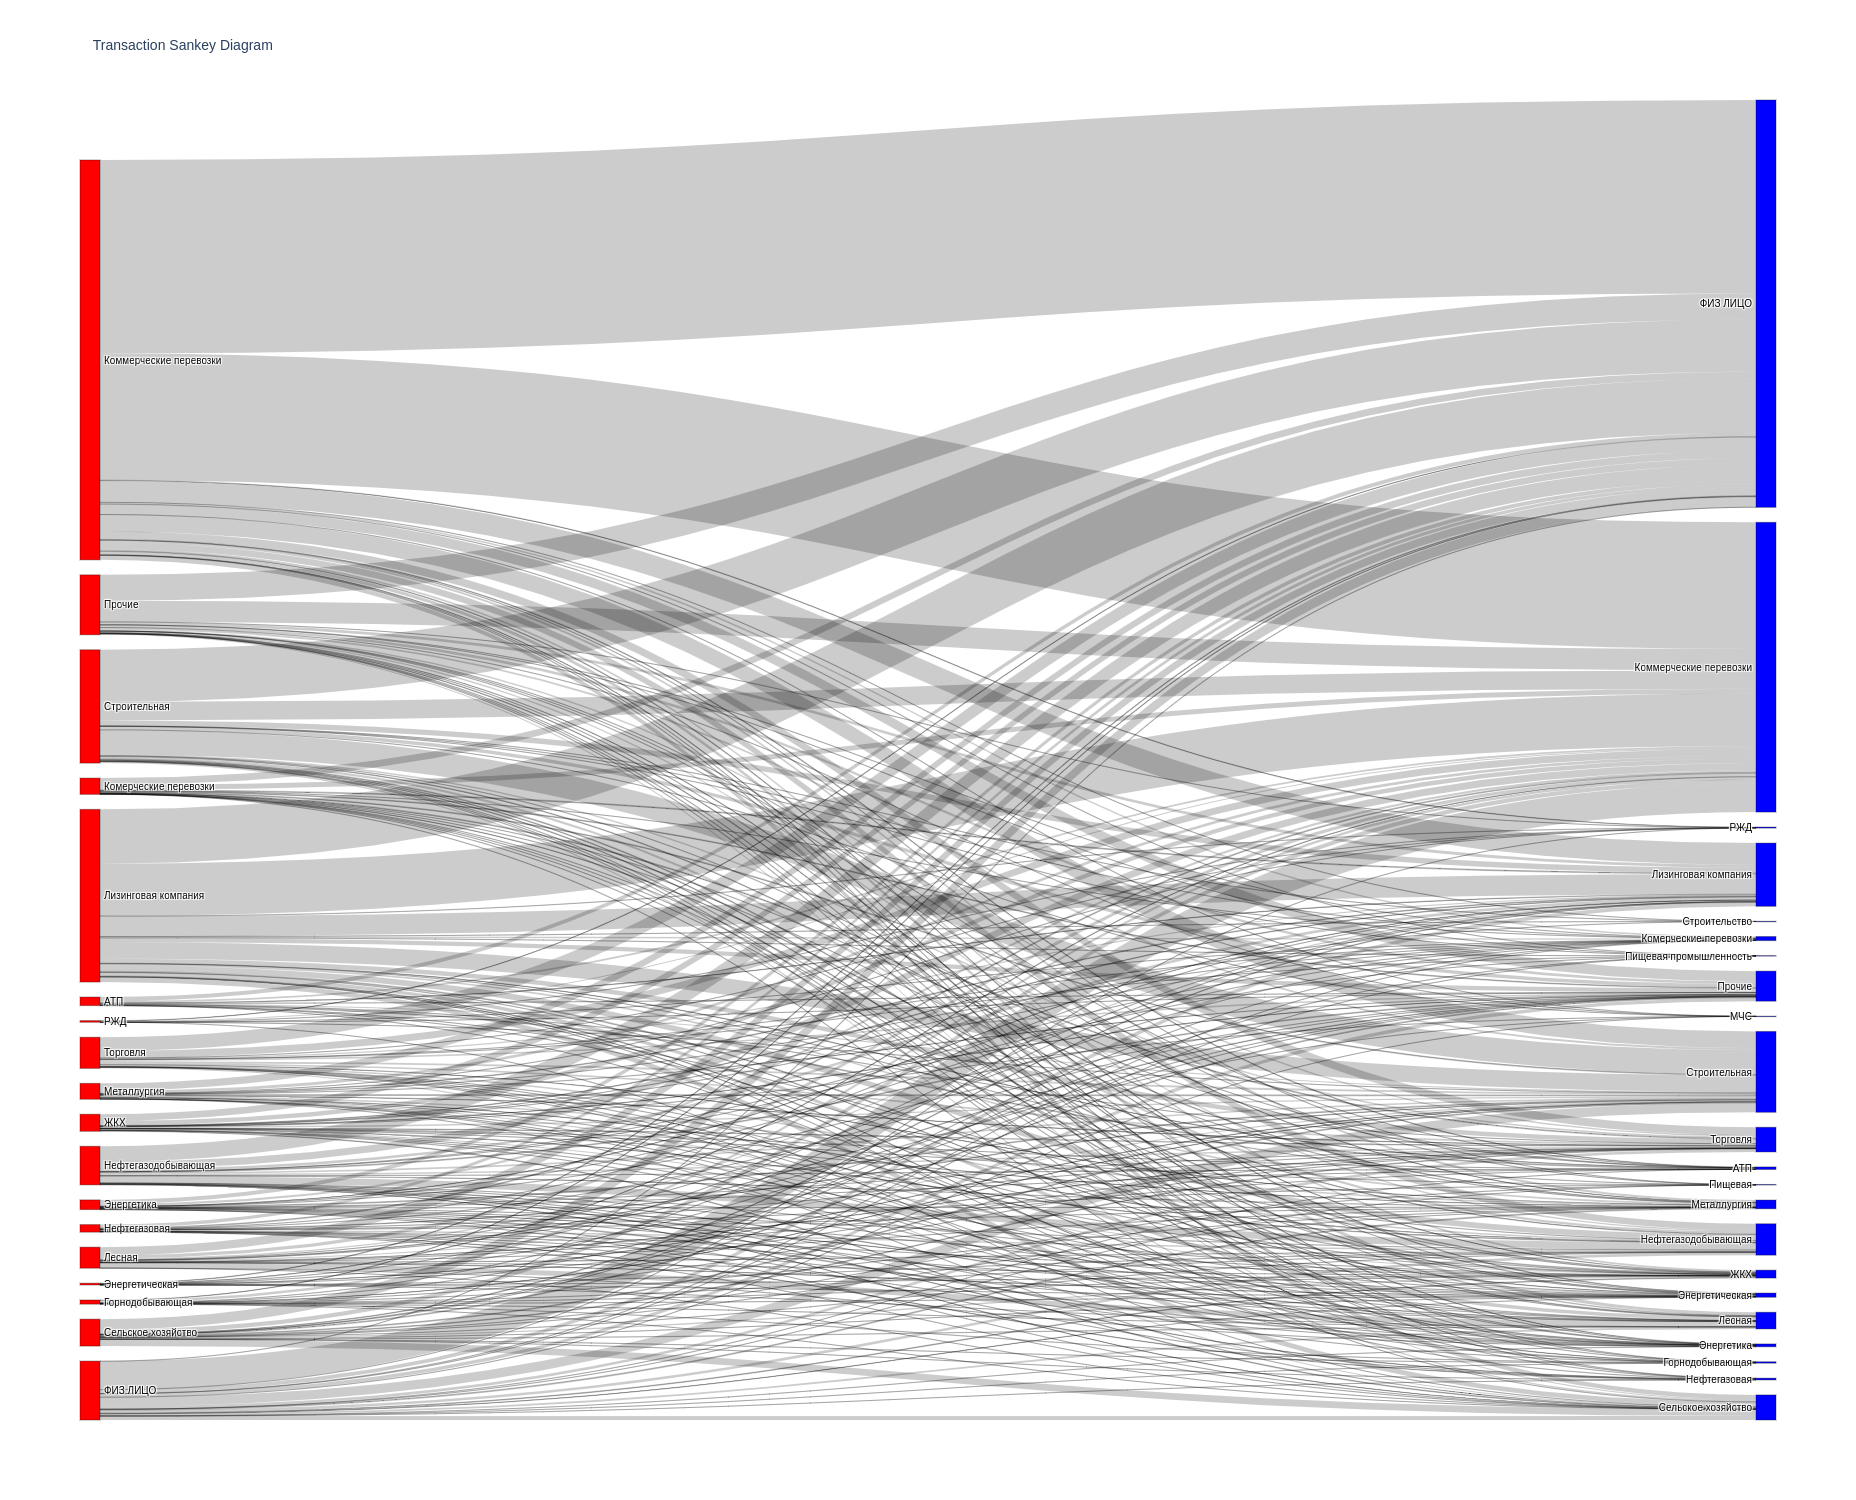

In [222]:
sankey(
    tmp,
    seller=seller_group,
    buyer=buyer_group,
    bipartite=True,
    display_nan=True,
    display_minor=False,
    drop_cycle=False,
    min_transaction_seller=100,
    min_transaction_buyer=100,
)

In [209]:
tmp['brand'].value_counts().index[0]

'MERCEDES-BENZ'

In [270]:
tmp = tmp[tmp['inn_seller'] != "INITIAL"]

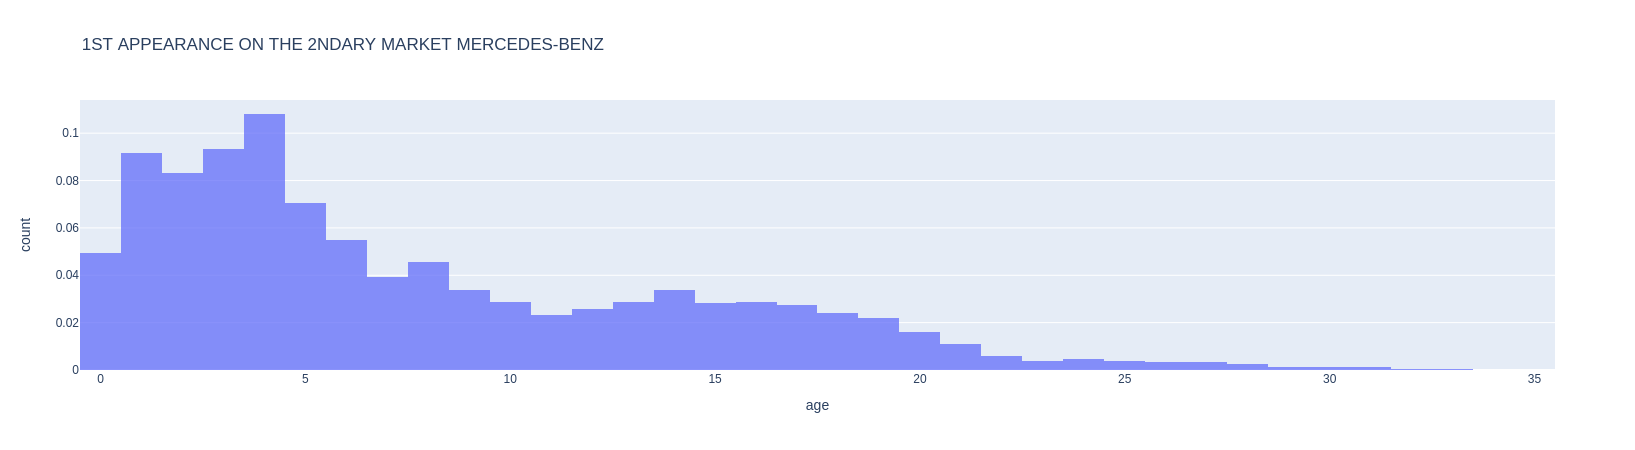

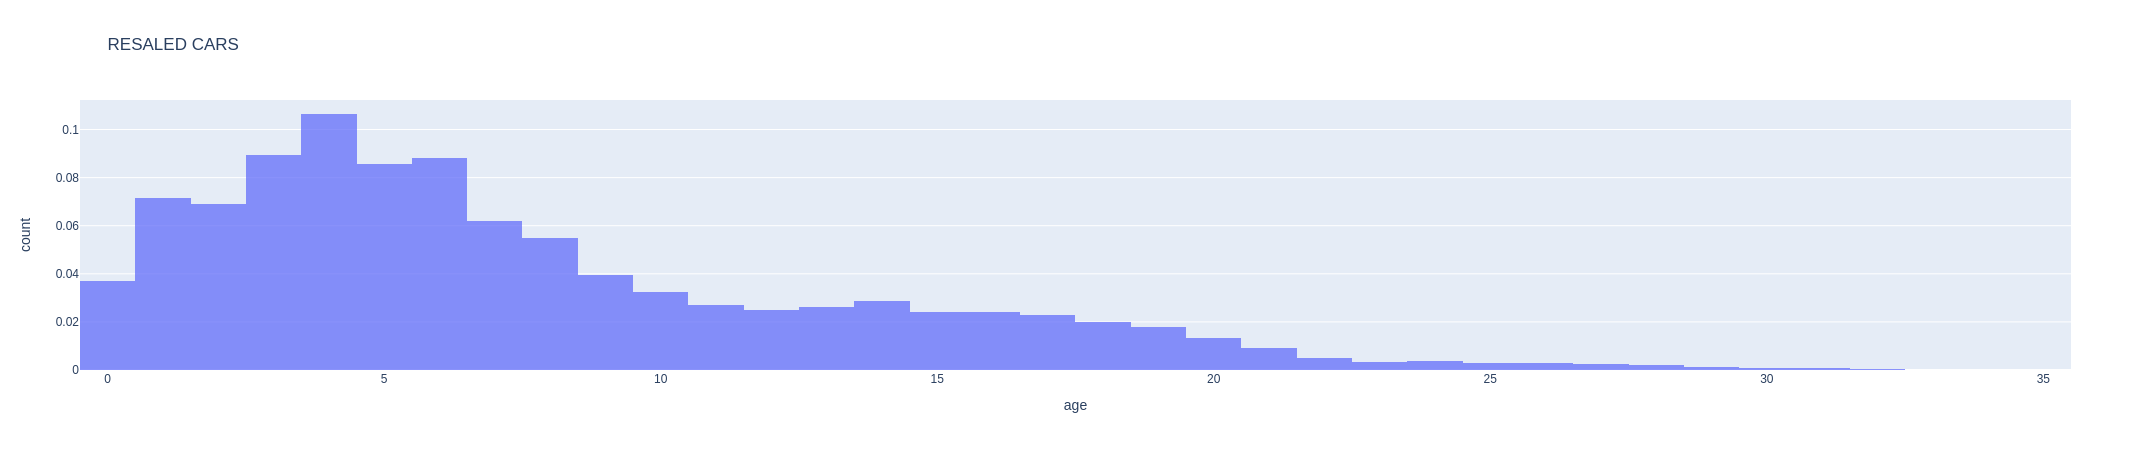

In [212]:
get_histogram(tmp)

In [226]:
buf = get_transacation_count(tmp, 'age', 'operation_year')

In [227]:
buf.to_excel("output.xlsx")

In [224]:
get_transacation_count(tmp, 'age', 'operation_year')

operation_year  2013  2014  2015  2016  2017  2018  2019  2020
age                                                           
0               4755   584   189   336   759   819   766    47
1               6493  1111   861   491   890  2322  1829   328
2               4582  3771  1672  1877  1034  1288  3289   494
3               2264  6355  5794  3852  3233  1479  2145   687
4                714  1921  6166  8703  3893  3007  1431   416
5               4654   515  1749  7639  6183  3627  2261   231
6               3419  3482   478  2515  6586  5865  2883   383
7               1760  2362  3467  1190  2303  5532  4833   343
8               1120  1255  1919  6490   975  2147  4784   636
9                969   667  1194  5199  5701   793  1801   533
10              1070   734   741  2908  4565  4680   693   234
11               584   657   694  2433  2503  3618  3962    90
12               549   502   681  3492  2204  1899  2971   433
13               523   458   467  4388  2879  1638  1586   354
14               475   404   437  3043  3718  2224  1288   161
15               368   344   413  1923  2519  2689  1753   117
16               292   255   357  2683  1761  1827  2071   157
17               263   223   243  2481  2410  1265  1362   182
18               224   149   212  1841  2378  1732   882   137
19               185   192   155  1123  1627  1612  1266    79
20               201   151   161   966   950  1206  1179   125
21               187   177   142  1138   907   697   802   103
22               166   127   171   736   925   657   532    58
23               116   132   142   723   626   663   451    42
24                89    80   132   753   616   448   478    28
25                78    73    87   681   675   429   308    36
26                49    47    90   517   610   455   270    36
27                22    32    43   391   437   471   331    24
28                11    15    38   285   304   313   337    25
29                 2     5    20   180   277   246   194    26
30                 4     8     2   111   178   178   163     6
31                 7     6     4    34    85   118   154    14
32                 0     1     1    32    39    62    85     8
33                 0     3     1    13    27    28    51    11
34                 0     0     3    14    14    18    23     6
35                 0     0     0     9    18    10     8     1
36                 0     0     0     0     7    13     7     2
37                 0     0     0     0     0     9     7     0
38                 0     0     0     0     0     0     6     0

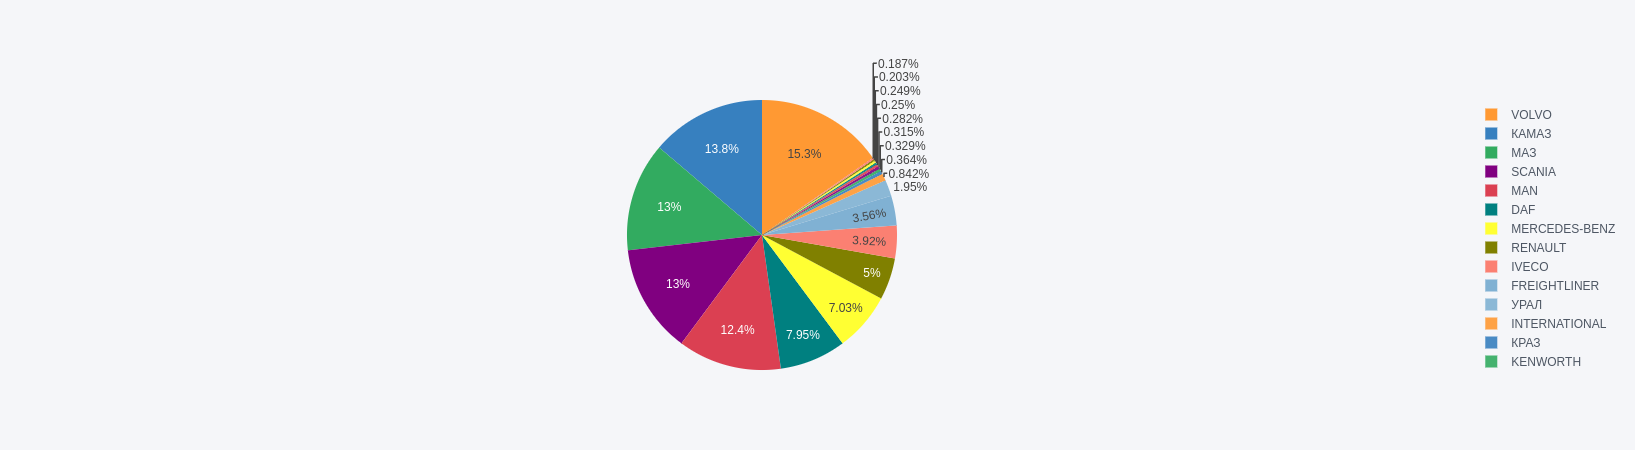

In [228]:
column = 'brand'
tmp.groupby('vin')[column].first().value_counts().head(20).reset_index().iplot('pie', values='brand', labels='index')

In [229]:
get_transacation_count(tmp, 'size_seller', 'size_buyer')

size_buyer           Крупные предприятия  Малые предприятия  Микропредприятия  \
size_seller                                                                     
Крупные предприятия                 1801               2576              3621   
Малые предприятия                    932               2733              4477   
Микропредприятия                    1042               2919              7518   
Средние предприятия                  537               1242              2226   

size_buyer           Средние предприятия  
size_seller                               
Крупные предприятия                 1271  
Малые предприятия                    512  
Микропредприятия                     929  
Средние предприятия                  248

In [137]:
tmp.head()

inn_seller   inn_buyer region_seller activity_field_seller  \
0        NaN  1117006246           NaN                   NaN   
1        NaN  6321304058           NaN                   NaN   
2        NaN  7422032998           NaN                   NaN   
3        NaN  6321304058           NaN                   NaN   
4        NaN  6321304058           NaN                   NaN   

          region_buyer activity_field_buyer                vin  brand  \
0                 Коми                 None  X52AT630S70000035  КАМАЗ   
1    Самарская область                 None  XLRTE85XC0E758580    DAF   
2  Челябинская область  Лизинговая компания  XTC651163C1252268  КАМАЗ   
3    Самарская область                 None  XLERTE85XC0E75785    DAF   
4    Самарская область                 None  XLRTE85XC0E758586    DAF   

  chassis_config    year        body_type     model  age operation_date  \
0            6x4  2007.0  Грузовые прочие      6520    6     2013-01-02   
1            8x4  2007.0  Тягач седельный  CF85.340    6     2013-01-03   
2            6x4  2012.0  Тягач седельный     65116    1     2013-01-03   
3            8x4  2007.0  Тягач седельный  CF85.340    6     2013-01-03   
4            8x4  2007.0  Тягач седельный  CF85.340    6     2013-01-03   

                                    operation_reason  operation_year  \
0  Изменение собственника по сделкам, произведенн...            2013   
1                          коррекция иных реквизитов            2013   
2  временная регистрация ТС (на срок проведения п...            2013   
3                          коррекция иных реквизитов            2013   
4                          коррекция иных реквизитов            2013   

  size_seller name_seller activity_seller status_seller activity_code_seller  \
0         NaN         NaN             NaN           NaN                  NaN   
1         NaN         NaN             NaN           NaN                  NaN   
2         NaN         NaN             NaN           NaN                  NaN   
3         NaN         NaN             NaN           NaN                  NaN   
4         NaN         NaN             NaN           NaN                  NaN   

  risk_seller group_seller upper_activity_seller        size_buyer  \
0         NaN          NaN                   NaN  Микропредприятия   
1         NaN          NaN                   NaN               NaN   
2         NaN          NaN                   NaN               NaN   
3         NaN          NaN                   NaN               NaN   
4         NaN          NaN                   NaN               NaN   

                 name_buyer                    activity_buyer status_buyer  \
0  ООО "КНЯЖПОГОСТСКАЯ ЛПК"  Распиловка и строгание древесины  Действующая   
1                6321304058                               NaN          NaN   
2                7422032998                               NaN          NaN   
3                6321304058                               NaN          NaN   
4                6321304058                               NaN          NaN   

  activity_code_buyer    risk_buyer               group_buyer  \
0               16.10  Средний риск  ООО "КНЯЖПОГОСТСКАЯ ЛПК"   
1                 NaN           NaN                6321304058   
2                 NaN           NaN                7422032998   
3                 NaN           NaN                6321304058   
4                 NaN           NaN                6321304058   

                                upper_activity_buyer  
0  Обработка древесины и производство изделий из ...  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [99]:
get_transacation_count(tmp, 'activity_field_seller', 'activity_field_buyer')

activity_field_buyer         АТП  Авиация  Геологоразведка  \
activity_field_seller                                        
АТП                           69        0                0   
Авиация                        0        0                0   
Геологоразведка                0        0               10   
Геологоразведывающая           0        0                0   
Горнодобывающая                0        0                1   
ЖКХ                            3        0                0   
Комерческие перевозки          1        0                0   
Коммерческие перевозки        46        0                0   
Легкая промышленность          0        0                0   
Лесная                         1        0                0   
Лизинговая компания           30        2                0   
МВД                            0        0                0   
МЧС                            0        0                0   
Металлургия                    0        0                0   
Нефтегазовая                   0        0                0   
Нефтегазодобывающая            4        4                0   
Оборонные предприятия          0        0                0   
Образовательное учереждение    0        0                0   
Образовательные учереждения    0        0                0   
Пищевая                        0        0                0   
Пищевая промышленность         0        0                0   
Почта России                   0        0                0   
Производство автомобилей       0        0                0   
Прочие                         1        0                0   
РЖД                            0        0                0   
Сельское хозяйство             0        0                0   
Строительная                  15        0                0   
Строительство                  0        0                0   
Торговля                       0        0                1   
ФИЗ ЛИЦО                       5        0                0   
Химическая                     0        0                0   
Энергетика                     3        0                0   
Энергетическая                 0        0                0   

activity_field_buyer         Геологоразведывающая  Горнодобывающая  ЖКХ  \
activity_field_seller                                                     
АТП                                             0                0    2   
Авиация                                         0                0    0   
Геологоразведка                                 2                0    0   
Геологоразведывающая                            0                0    0   
Горнодобывающая                                 0               20    1   
ЖКХ                                             0                0   71   
Комерческие перевозки                           0                0    4   
Коммерческие перевозки                          1               11  130   
Легкая промышленность                           0                0    0   
Лесная                                          0                0    5   
Лизинговая компания                             2               24   70   
МВД                                             0                0    0   
МЧС                                             0                0    1   
Металлургия                                     0                1    3   
Нефтегазовая                                    1                0    1   
Нефтегазодобывающая                             0                1   15   
Оборонные предприятия                           0                0    0   
Образовательное учереждение                     0                1    0   
Образовательные учереждения                     0                0    0   
Пищевая                                         0                0    7   
Пищевая промышленность                          0                0    0   
Почта России                                    0                0    0   
Производство автомобилей     

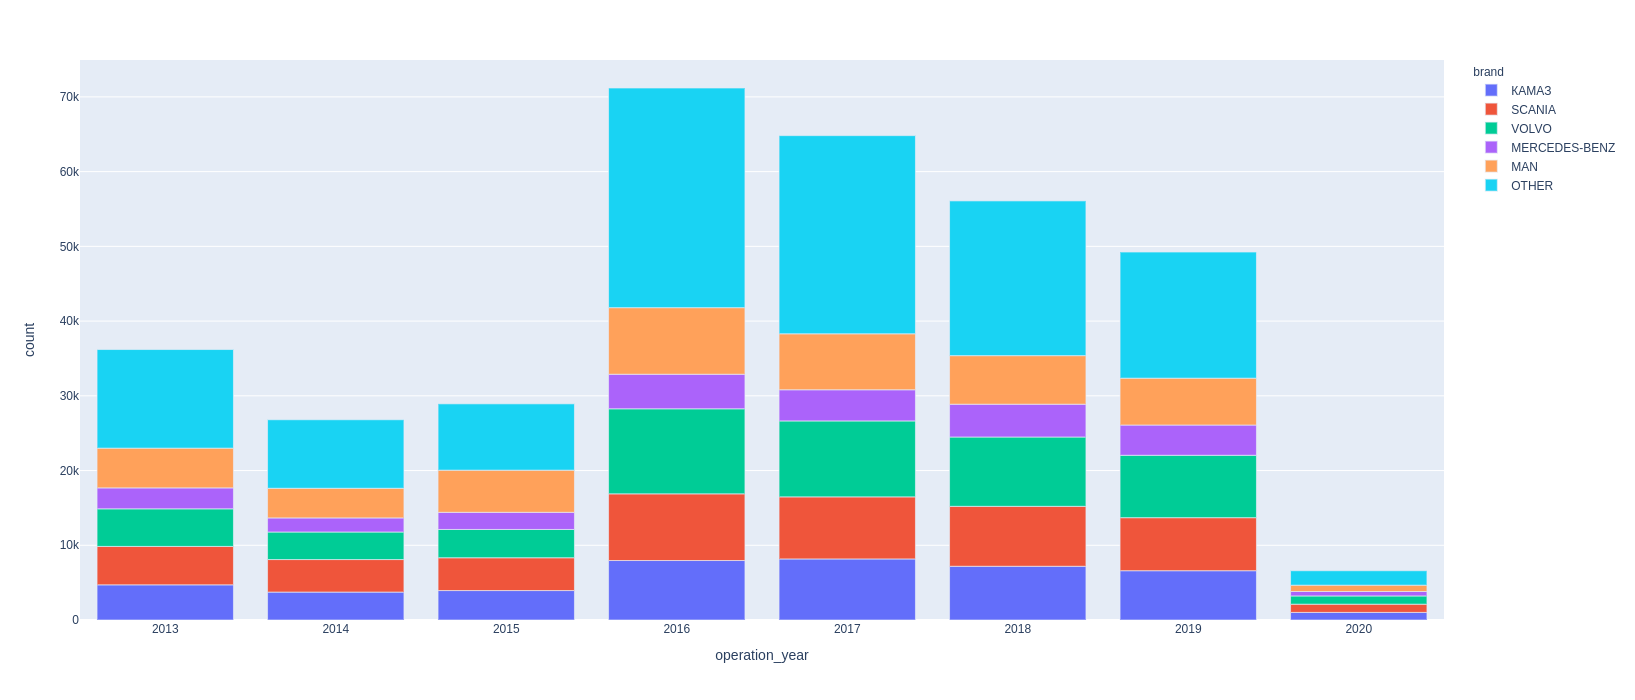

In [317]:
top_brand = [
    'КАМАЗ',
    'SCANIA',
    'VOLVO',
    'MERCEDES-BENZ',
    'MAN',
]

tmp.loc[~tmp['brand'].isin(top_brand), 'brand'] = 'OTHER'

tr = get_transacation_count(tmp.query('inn_seller != "INITIAL"'), 'operation_year', 'brand')

px.bar(tr.unstack().to_frame('count').reset_index().set_index('brand').loc[top_brand+['OTHER']].reset_index(), x='operation_year', y='count', color='brand', height=700)

In [264]:
tmp['value'] = 1

In [261]:
top_0_4 = [
    0,
    1,
    2,
    3,
    4,
]

top_0_9 = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
]

top_5_9 = [
    5,
    6,
    7,
    8,
    9,
]

tmp.loc[~tmp['age'].isin(top_0_9), 'age'] = 'From 10'
tmp.loc[tmp['age'].isin(top_0_4), 'age'] = '0 - 4'
tmp.loc[tmp['age'].isin(top_5_9), 'age'] = '5 - 9'

In [262]:
tmp

inn_seller   inn_buyer         region_seller   activity_field_seller  \
0              NaN  6321304058                   NaN                     NaN   
1              NaN  7422032998                   NaN                     NaN   
2              NaN  6321304058                   NaN                     NaN   
3              NaN  6321304058                   NaN                     NaN   
4              NaN  6321304058                   NaN                     NaN   
...            ...         ...                   ...                     ...   
479948  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479950  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479951  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479952  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479953  6663006255  0272906610  Свердловская область  Коммерческие перевозки   

               region_buyer activity_field_buyer                vin    brand  \
0         Самарская область                 None  XLRTE85XC0E758580      DAF   
1       Челябинская область  Лизинговая компания  XTC651163C1252268    КАМАЗ   
2         Самарская область                 None  XLERTE85XC0E75785      DAF   
3         Самарская область                 None  XLRTE85XC0E758586      DAF   
4         Самарская область                 None  XLRTE85XC0E758563      DAF   
...                     ...                  ...                ...      ...   
479948         Башкортостан                 None  VF625GPA000001698  RENAULT   
479950         Башкортостан                 None  XIP442020X0238481     УРАЛ   
479951         Башкортостан                 None  XTC652213C1269038    КАМАЗ   
479952         Башкортостан                 None  X1P44202051312854     УРАЛ   
479953         Башкортостан                 None  X9PAS02A3CW107888    VOLVO   

       chassis_config    year        body_type     model      age  \
0                 8x4  2007.0  Тягач седельный  CF85.340    5 - 9   
1                 6x4  2012.0  Тягач седельный     65116    0 - 4   
2                 8x4  2007.0  Тягач седельный  CF85.340    5 - 9   
3                 8x4  2007.0  Тягач седельный  CF85.340    5 - 9   
4                 8x4  2007.0  Тягач седельный  CF85.340    5 - 9   
...               ...     ...              ...       ...      ...   
479948            4x2  2007.0  Тягач седельный     HR380  From 10   
479950            6x6  1999.0  Тягач седельный     44202  From 10   
479951            6x6  2012.0  Тягач седельный     65221    5 - 9   
479952            6x6  2005.0  Тягач седельный     44202  From 10   
479953            4x2  2012.0  Тягач седельный  FH TRUCK    5 - 9   

       operation_date                                   operation_reason  \
0          2013-01-03                          коррекция иных реквизитов   
1          2013-01-03  временная регистрация ТС (на срок проведения п...   
2          2013-01-03                          коррекция иных реквизитов   
3          2013-01-03                          коррекция иных реквизитов   
4          2013-01-03                          коррекция иных реквизитов   
...               ...                                                ...   
479948     2020-03-31  Изменение собственника по сделкам, произведенн...   
479950     2020-03-31  Изменение собственника по сделкам, произведенн...   
479951     2020-03-31  Изменение собственника по сделкам, произведенн...   
479952     2020-03-31     замена государственного регистрационного знака   
479953     2020-03-31                        регистрация, снятых с учета   

        operation_year          size_seller      name_seller  \
0                 2013                  NaN              NaN   
1                 2013                  NaN              NaN   
2                 2013                  NaN              NaN   
3                 2013                  NaN              NaN   
4                 2013  

In [265]:
tmp.groupby(['operation_year', 'age'])['value'].count().reset_index()

operation_year      age  value
0             2013    0 - 4  18808
1             2013    5 - 9  11922
2             2013  From 10   5465
3             2014    0 - 4  13742
4             2014    5 - 9   8281
5             2014  From 10   4775
6             2015    0 - 4  14682
7             2015    5 - 9   8807
8             2015  From 10   5437
9             2016    0 - 4  15259
10            2016    5 - 9  23033
11            2016  From 10  32898
12            2017    0 - 4   9809
13            2017    5 - 9  21748
14            2017  From 10  33259
15            2018    0 - 4   8915
16            2018    5 - 9  17964
17            2018  From 10  29205
18            2019    0 - 4   9460
19            2019    5 - 9  16562
20            2019  From 10  23220
21            2020    0 - 4   1972
22            2020    5 - 9   2126
23            2020  From 10   2495

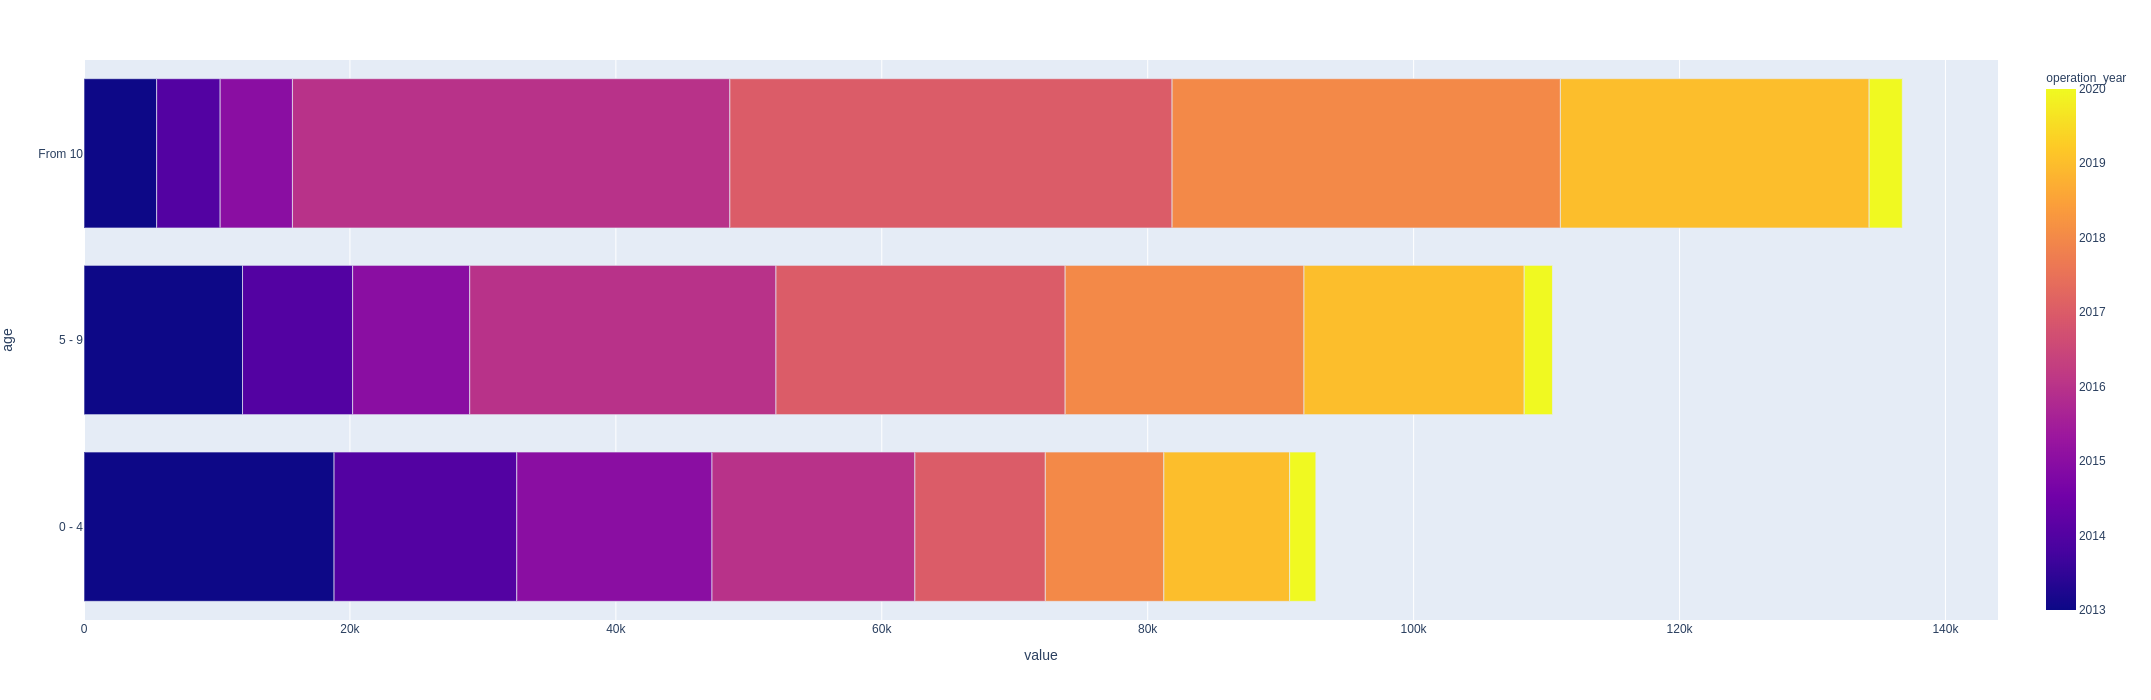

In [266]:
px.bar(tmp.groupby(['operation_year', 'age'])['value'].count().reset_index(), x='value', y='age', color='operation_year', height=700, orientation='h')

In [443]:
top_brand = [
    'КАМАЗ',
    'SCANIA',
    'VOLVO',
    'MERCEDES-BENZ',
    'MAN',
]

In [ ]:
tmp

In [453]:
res = []
for brand in top_brand:
    carpark = tmp.query('inn_seller != "INITIAL"').query('brand == @brand')
    age_list = carpark.groupby('age')['vin'].agg(set).tolist()
    vin_iter = set({})

    for i in range(len(age_list)):

        vin_iter.update(age_list[i])
        age_list[i] = copy(vin_iter)
        
    r = pd.DataFrame([[len(age), i] for i, age in enumerate(age_list)], columns=['count', 'age'])
    r['brand'] = brand
    res.append(r)

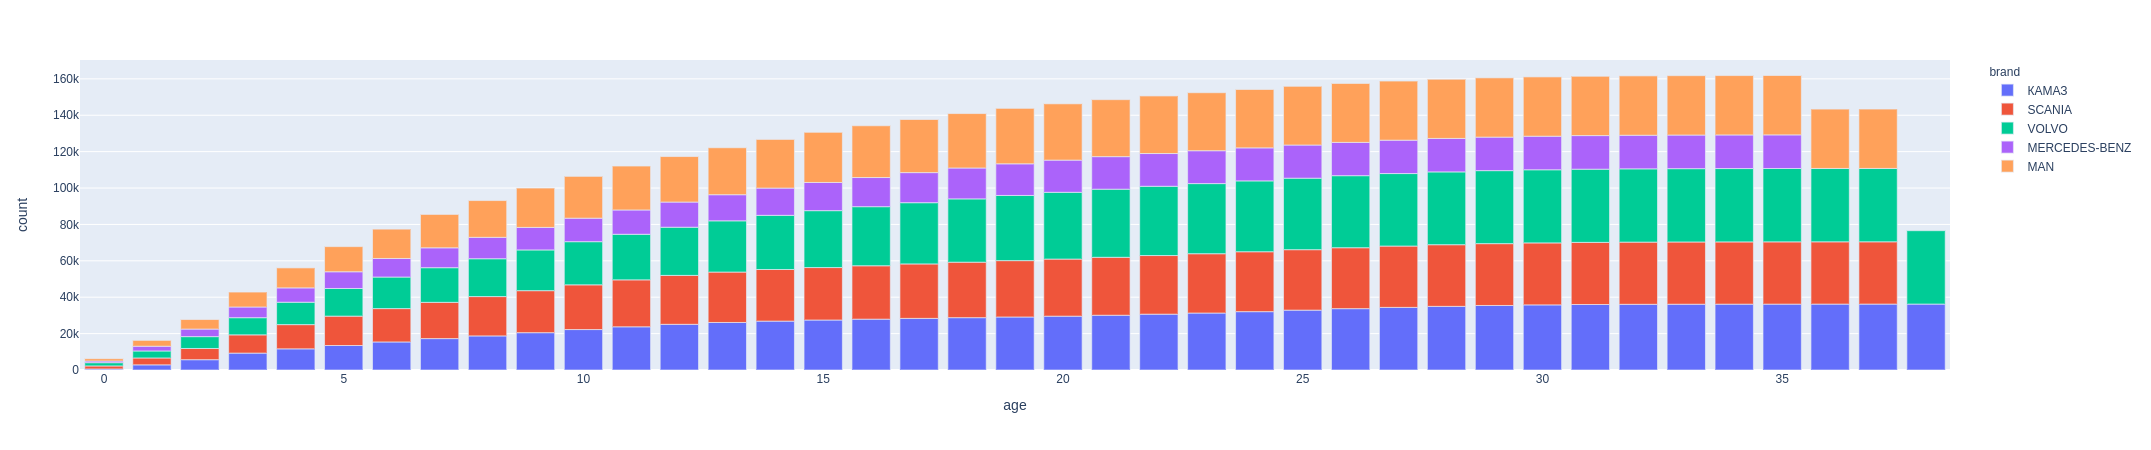

In [458]:
px.bar(pd.concat(res), x='age', y='count', color='brand')
# .iplot('bar', x='age', y='count', color='brand')

In [424]:
n_car = tmp.query('inn_seller != "INITIAL"')['vin'].nunique()

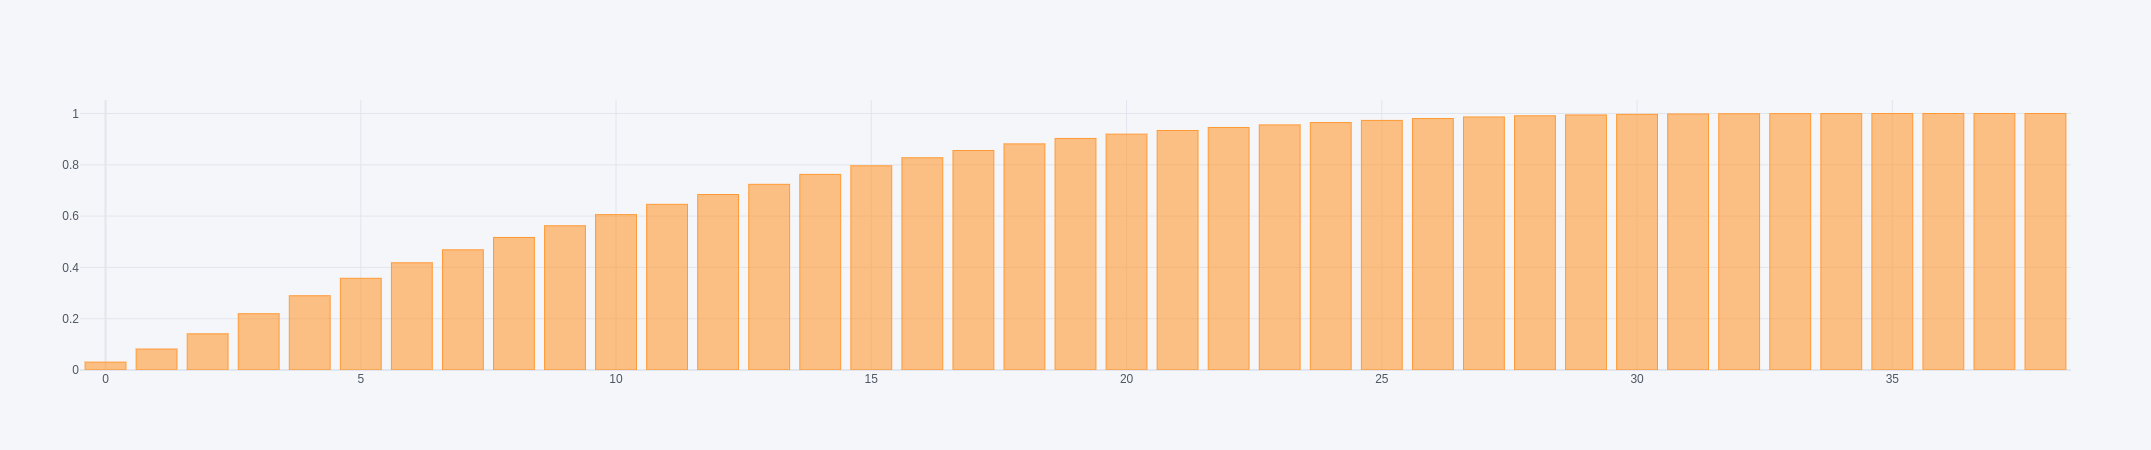

In [425]:
pd.DataFrame([[len(age)/n_car, i] for i, age in enumerate(age_list)], columns=['count', 'age']).iplot('bar', x='age', y='count')

In [429]:
%time age_list = tmp.query('inn_seller != "INITIAL"').groupby(['brand', 'age'])['vin'].agg(list)#.tolist()
# vin_iter = set({})

# for i in range(len(age_list)):
    
#     vin_iter.update(age_list[i])
#     age_list[i] = copy(vin_iter)

CPU times: user 334 ms, sys: 11.1 ms, total: 345 ms
Wall time: 343 ms


In [434]:
set([1,2], [2,3])

TypeError: set expected at most 1 arguments, got 2

In [437]:
age_list.groupby('brand').shift().

brand  age
MAN    0                                                    NaN
       1      [WMA30XZZ8DM619714, WMA06WZZ1DW182557, WMA06WZ...
       2      [WMA06WZZ3DW181216, WMA06WZZ7DW181218, WMA06WZ...
       3      [WMA06WZZ4BM577535, WMA06WZZ9BM577532, WMA06XZ...
       4      [WMA06WZZ1BP023593, WMA06WZZ6BP026053, WMA06WZ...
                                    ...                        
КАМАЗ  34     [XTC65115C32187478, XTC541000P2051437, XTC5410...
       35     [XTC541000C0153374, XTC541150Y2139847, XTC5411...
       36     [XTC541000P1052304, XTC541000P1055372, XTC5411...
       37     [XTC541000P2056128, XTC541000P1050716, XTC5410...
       38     [XTC54115032205534, XTC532000P2035845, XTC5410...
Name: vin, Length: 228, dtype: object

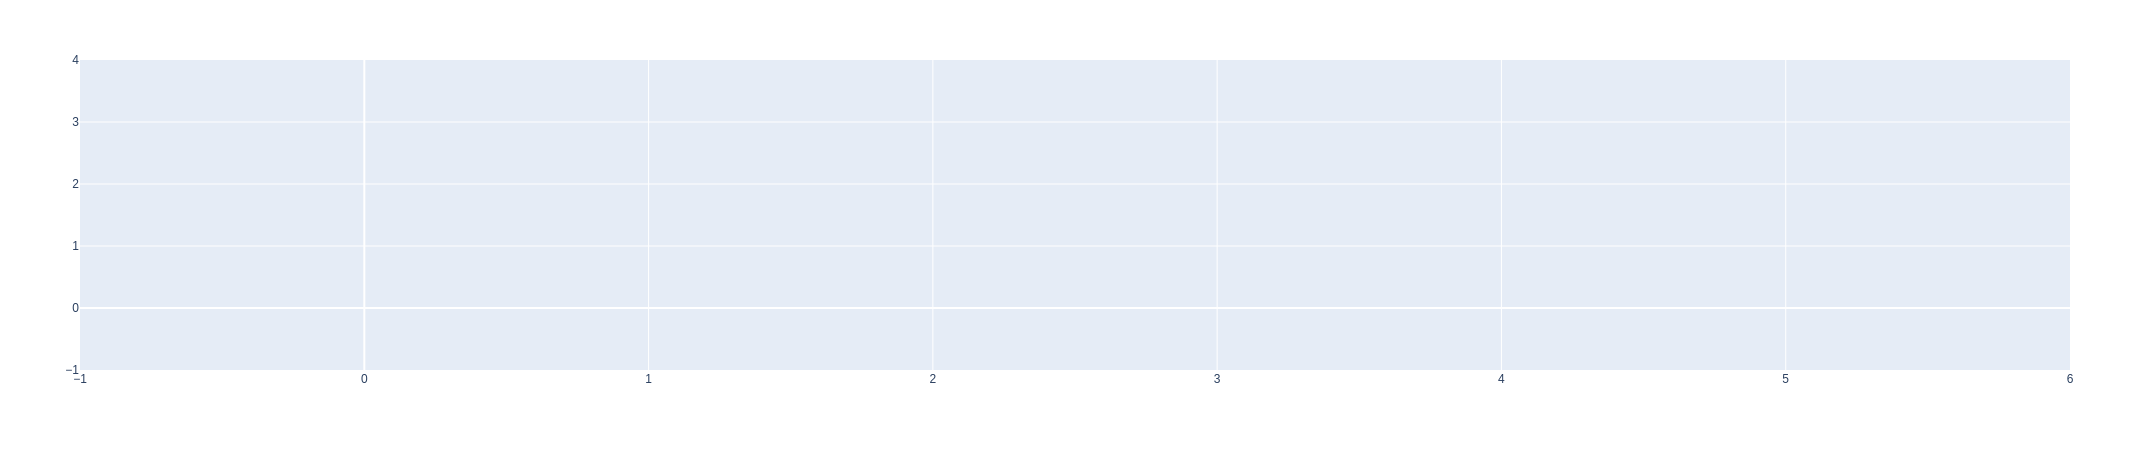

In [417]:
px.bar()

In [271]:
#age_set.tolist()

In [368]:
tmp['vin'].nunique()

375783

In [378]:
age_set.loc[[0, 1]]

age
0    {X89441080D0DM6044, Y3M5440B9H0001279, KMEFA18...
1    {YS2P6X40002096904, YV2ASG0A9DB640885, X1P4420...
Name: vin, dtype: object

In [371]:
for age in tmp['age'].unique():
    print(len(age_set.loc[age]))

24656
13853
16414
24644
25671
24507
17234
20531
6168
2352
15146
4872
3336
12499
12104
14173
8301
7479
11542
2860
18797
9984
9279
2060
8139
1731
2599
419
4110
1317
943
645
132
227
77
44
29
16
5


In [370]:
len(age_set.loc[0])

8139

In [360]:
tmp.sort_values('operation_year').groupby('vin')['age'].first

inn_seller   inn_buyer         region_seller   activity_field_seller  \
0              NaN  6321304058                   NaN                     NaN   
1              NaN  7422032998                   NaN                     NaN   
2              NaN  6321304058                   NaN                     NaN   
3              NaN  6321304058                   NaN                     NaN   
4              NaN  6321304058                   NaN                     NaN   
...            ...         ...                   ...                     ...   
479949     INITIAL  7457007417                   NaN                     NaN   
479950  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479951  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479952  7706660065  0274089610          Башкортостан     Нефтегазодобывающая   
479953  6663006255  0272906610  Свердловская область  Коммерческие перевозки   

               region_buyer activity_field_buyer                vin  brand  \
0         Самарская область                 None  XLRTE85XC0E758580  OTHER   
1       Челябинская область  Лизинговая компания  XTC651163C1252268  КАМАЗ   
2         Самарская область                 None  XLERTE85XC0E75785  OTHER   
3         Самарская область                 None  XLRTE85XC0E758586  OTHER   
4         Самарская область                 None  XLRTE85XC0E758563  OTHER   
...                     ...                  ...                ...    ...   
479949  Челябинская область                 None  VF611A362HD008377  OTHER   
479950         Башкортостан                 None  XIP442020X0238481  OTHER   
479951         Башкортостан                 None  XTC652213C1269038  КАМАЗ   
479952         Башкортостан                 None  X1P44202051312854  OTHER   
479953         Башкортостан                 None  X9PAS02A3CW107888  VOLVO   

       chassis_config    year        body_type        model  age  \
0                 8x4  2007.0  Тягач седельный     CF85.340    6   
1                 6x4  2012.0  Тягач седельный        65116    1   
2                 8x4  2007.0  Тягач седельный     CF85.340    6   
3                 8x4  2007.0  Тягач седельный     CF85.340    6   
4                 8x4  2007.0  Тягач седельный     CF85.340    6   
...               ...     ...              ...          ...  ...   
479949            4x2  2017.0  Тягач седельный  HD001 T 4X2    3   
479950            6x6  1999.0  Тягач седельный        44202   21   
479951            6x6  2012.0  Тягач седельный        65221    8   
479952            6x6  2005.0  Тягач седельный        44202   15   
479953            4x2  2012.0  Тягач седельный     FH TRUCK    8   

       operation_date                                   operation_reason  \
0          2013-01-03                          коррекция иных реквизитов   
1          2013-01-03  временная регистрация ТС (на срок проведения п...   
2          2013-01-03                          коррекция иных реквизитов   
3          2013-01-03                          коррекция иных реквизитов   
4          2013-01-03                          коррекция иных реквизитов   
...               ...                                                ...   
479949     2020-03-31                              первичная регистрация   
479950     2020-03-31  Изменение собственника по сделкам, произведенн...   
479951     2020-03-31  Изменение собственника по сделкам, произведенн...   
479952     2020-03-31     замена государственного регистрационного знака   
479953     2020-03-31                        регистрация, снятых с учета   

        operation_year          size_seller      name_seller  \
0                 2013                  NaN              NaN   
1                 2013                  NaN              NaN   
2                 2013                  NaN              NaN   
3                 2013                  NaN              NaN   
4                 2013                  NaN              NaN

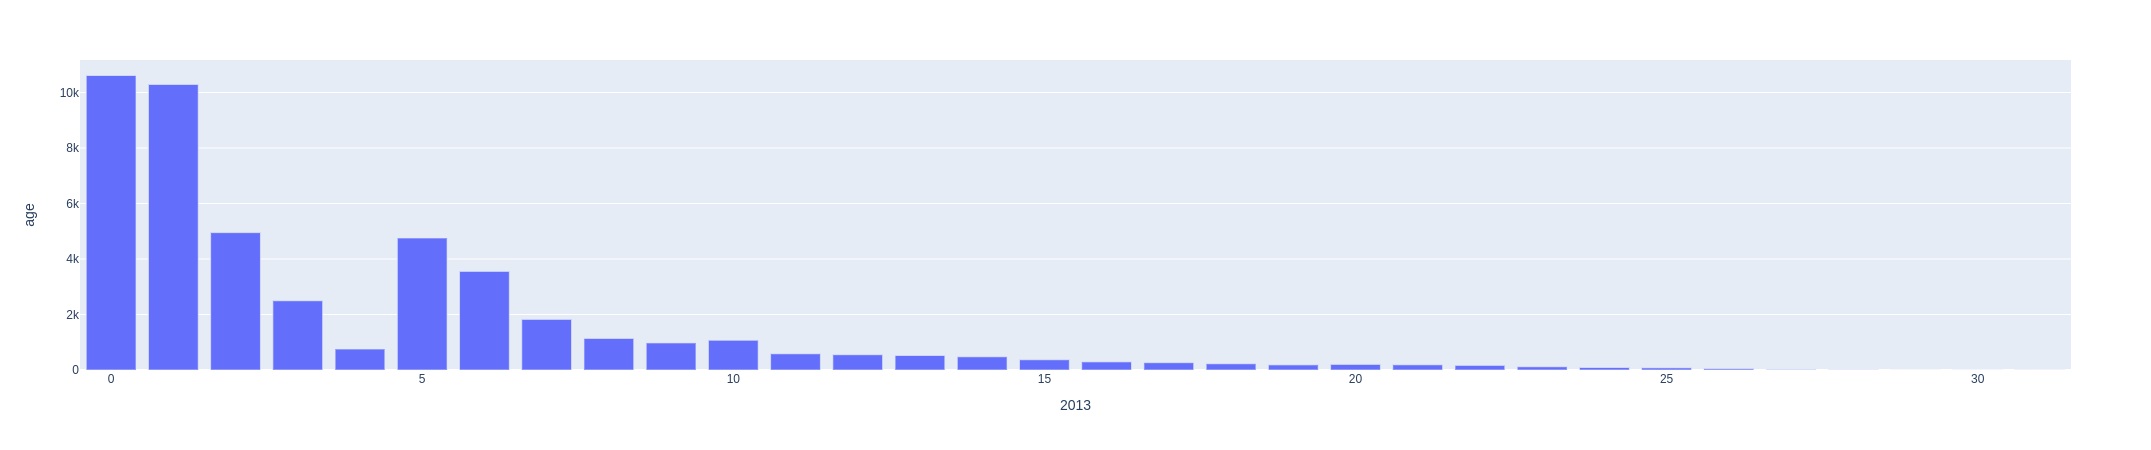

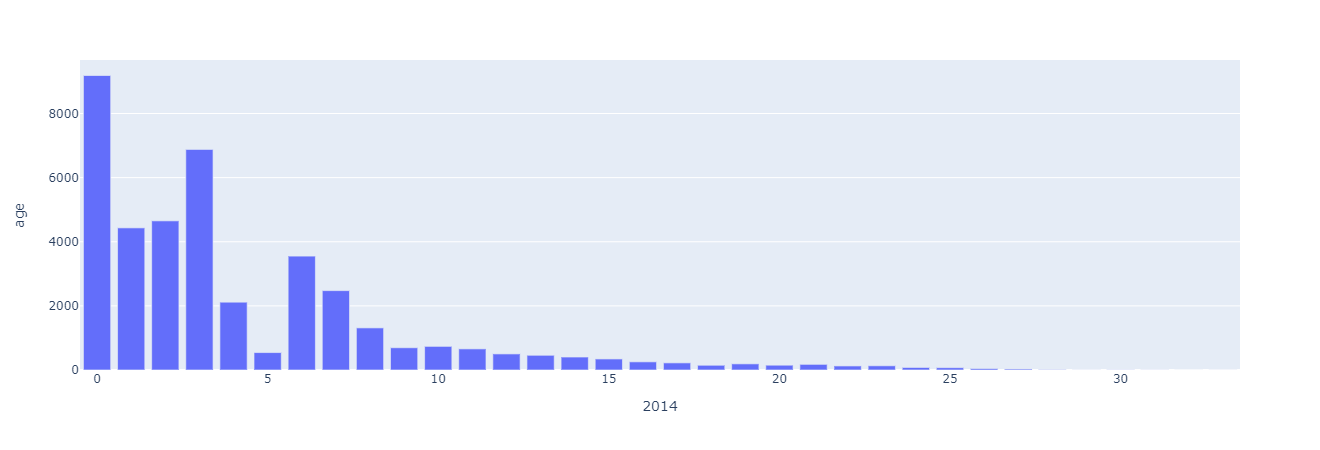

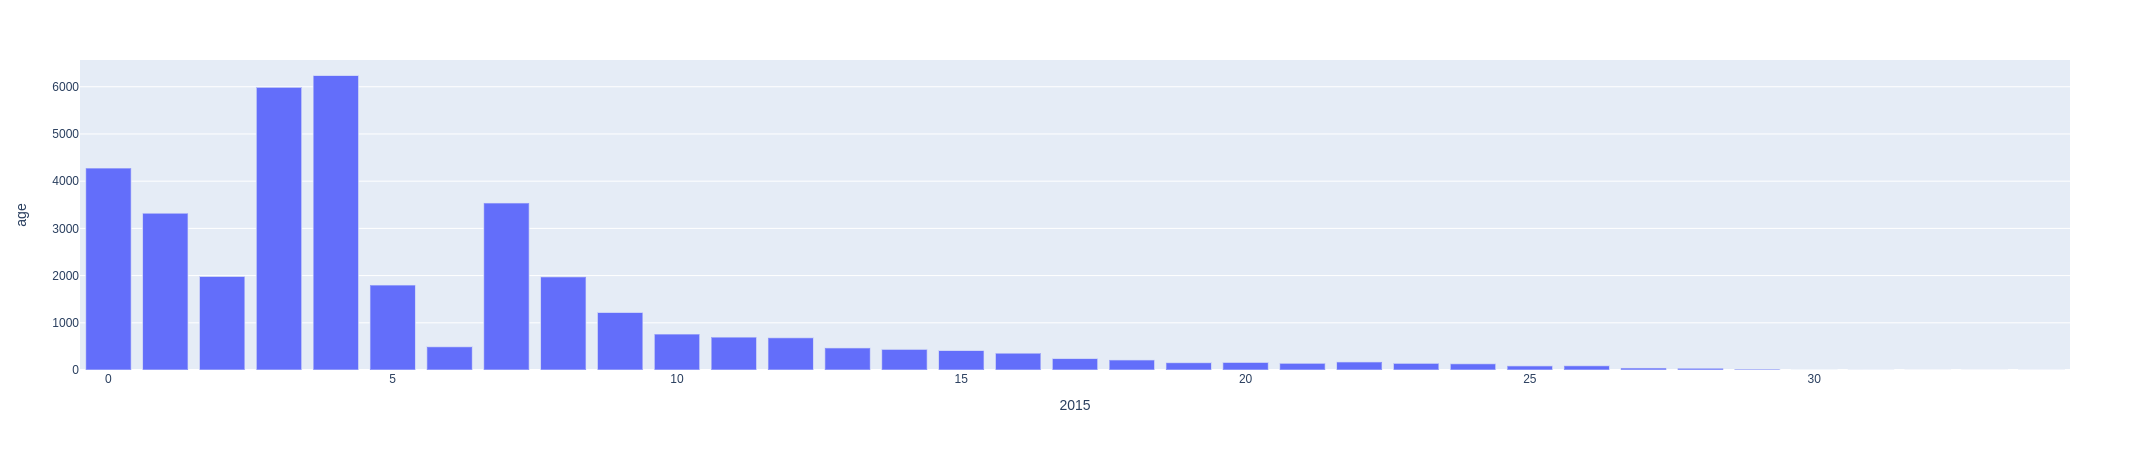

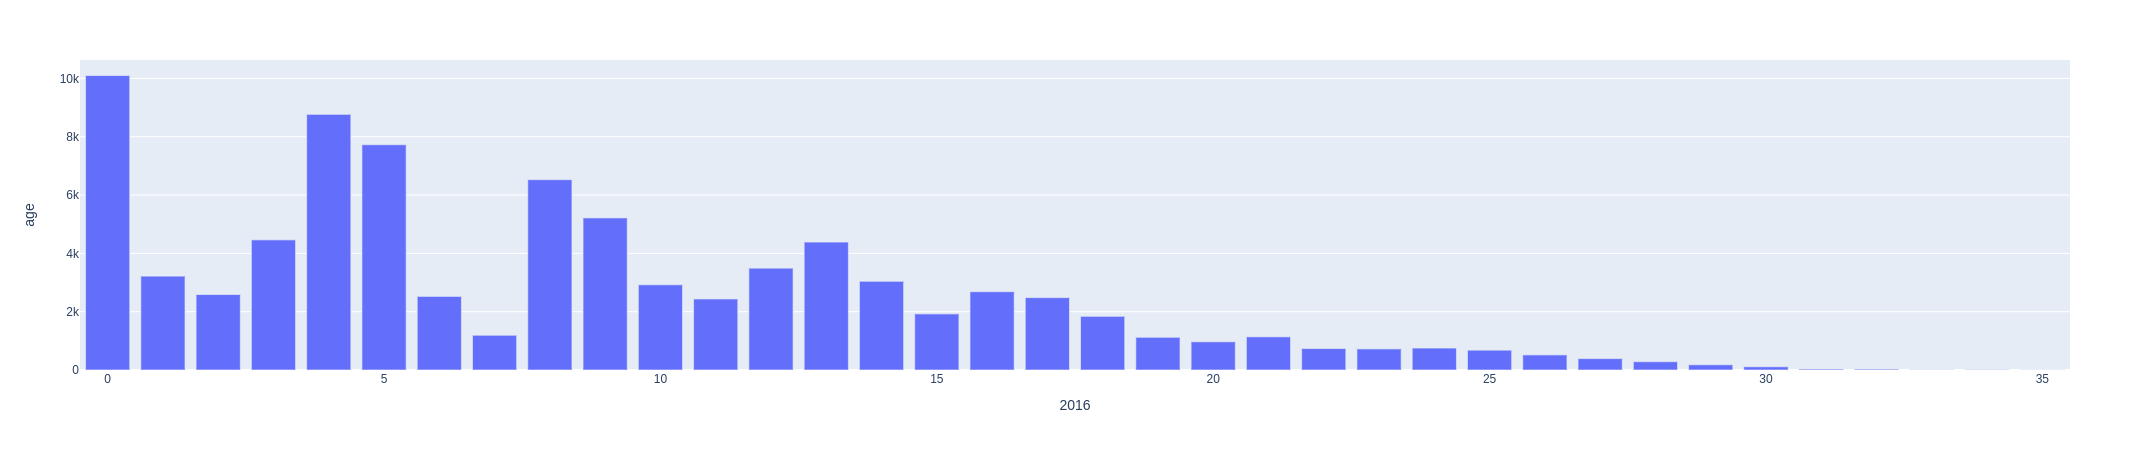

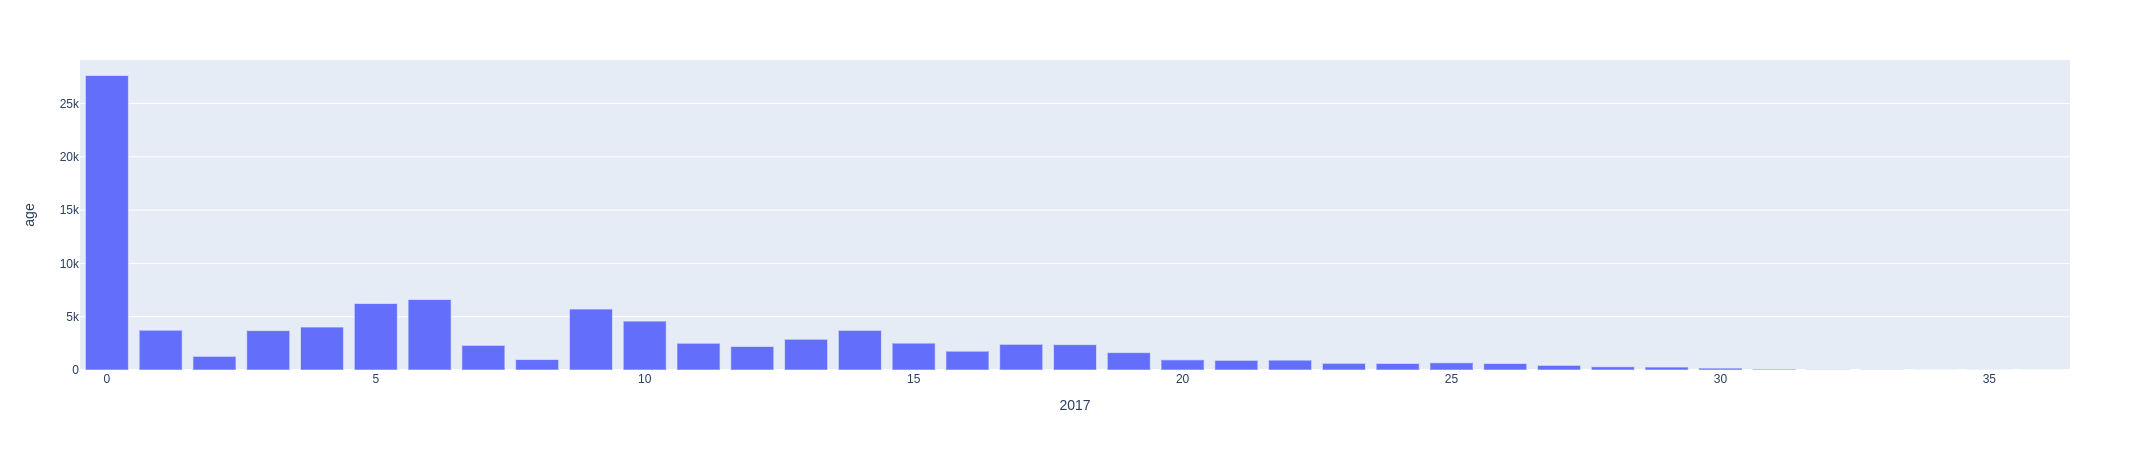

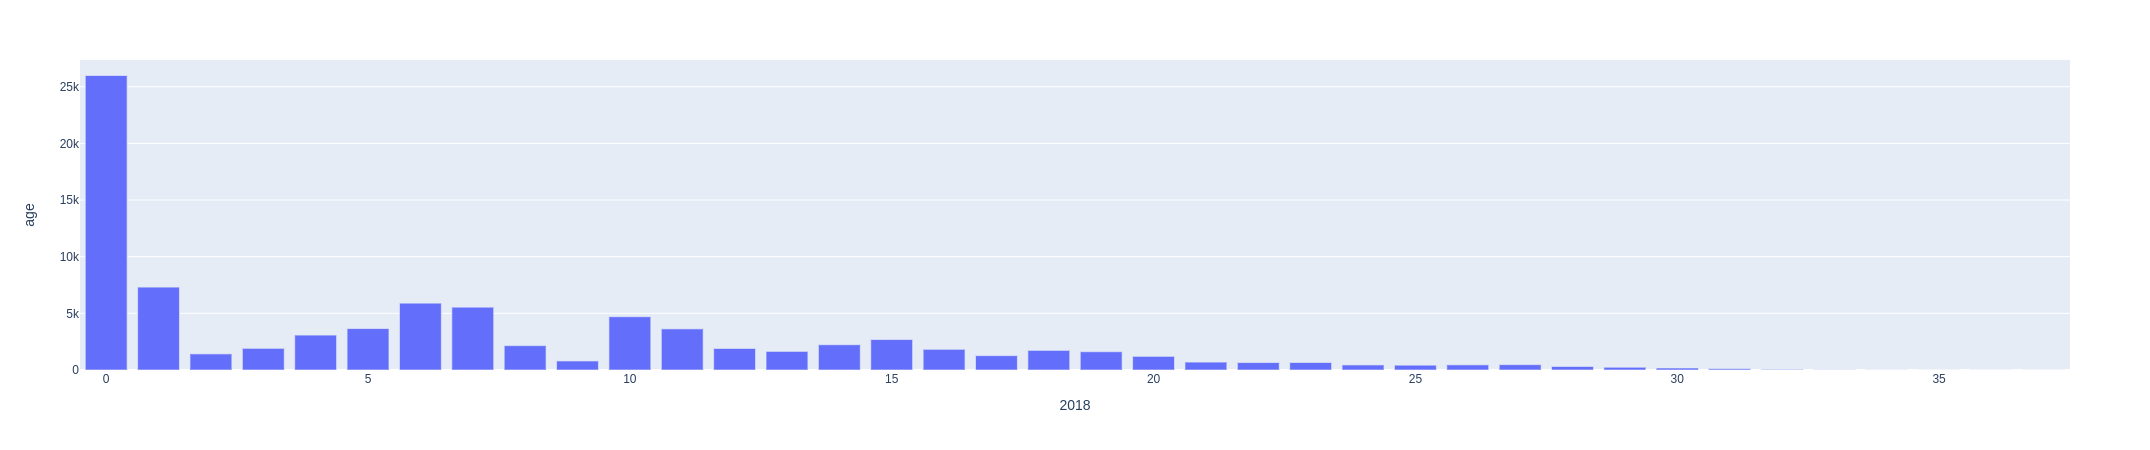

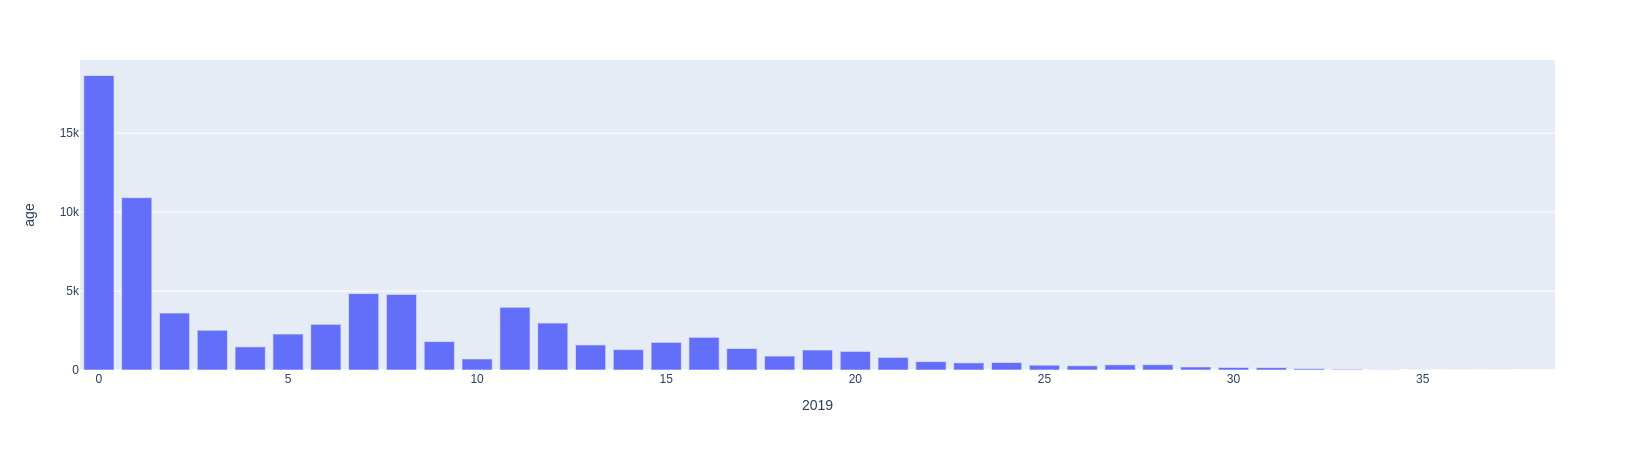

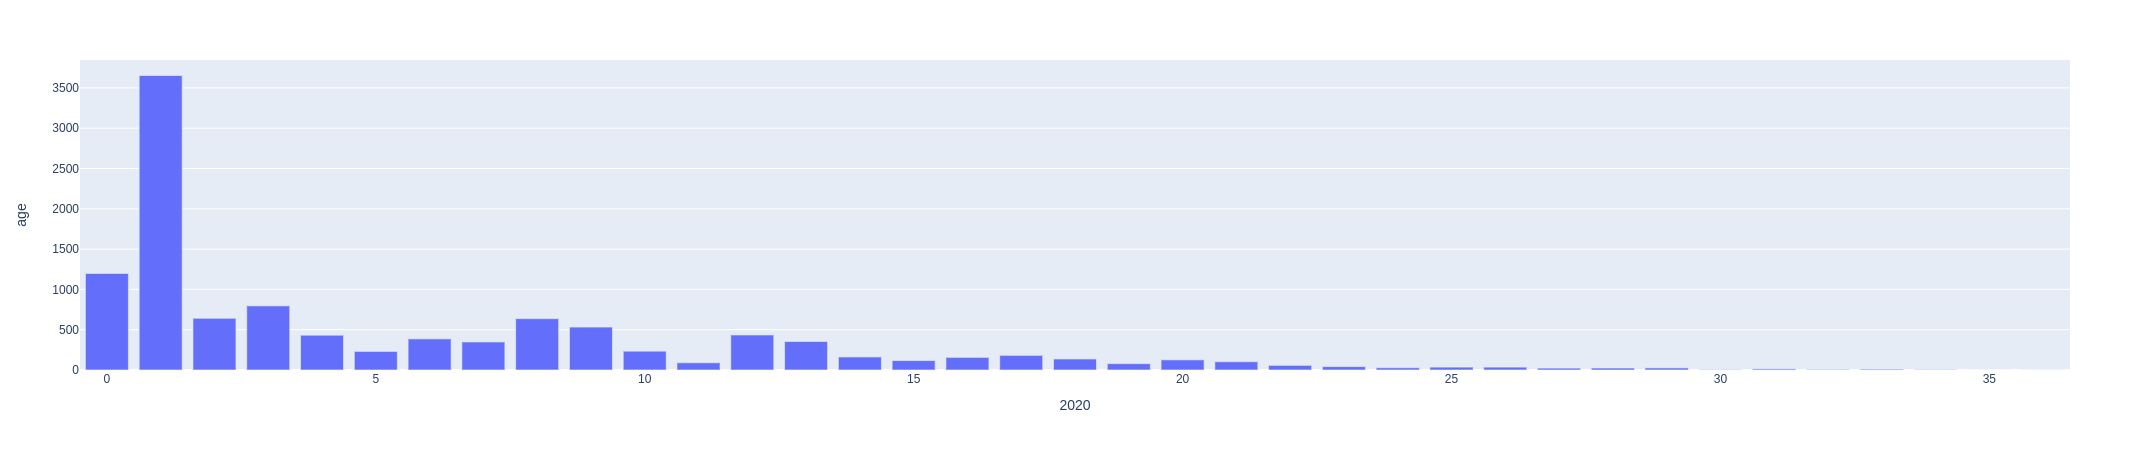

In [353]:
for year in tmp['operation_year'].unique():
    fig = px.bar(tmp.query('operation_year == @year')['age'].value_counts().sort_index().reset_index().rename({'index':str(year)}, axis=1), x=str(year), y='age')
    fig.show()

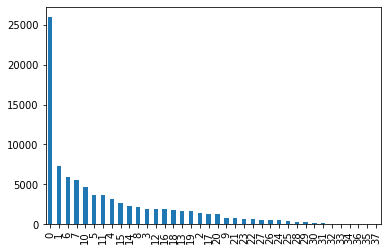

In [337]:
tmp.loc[tmp['operation_year'] == 2018, 'age']

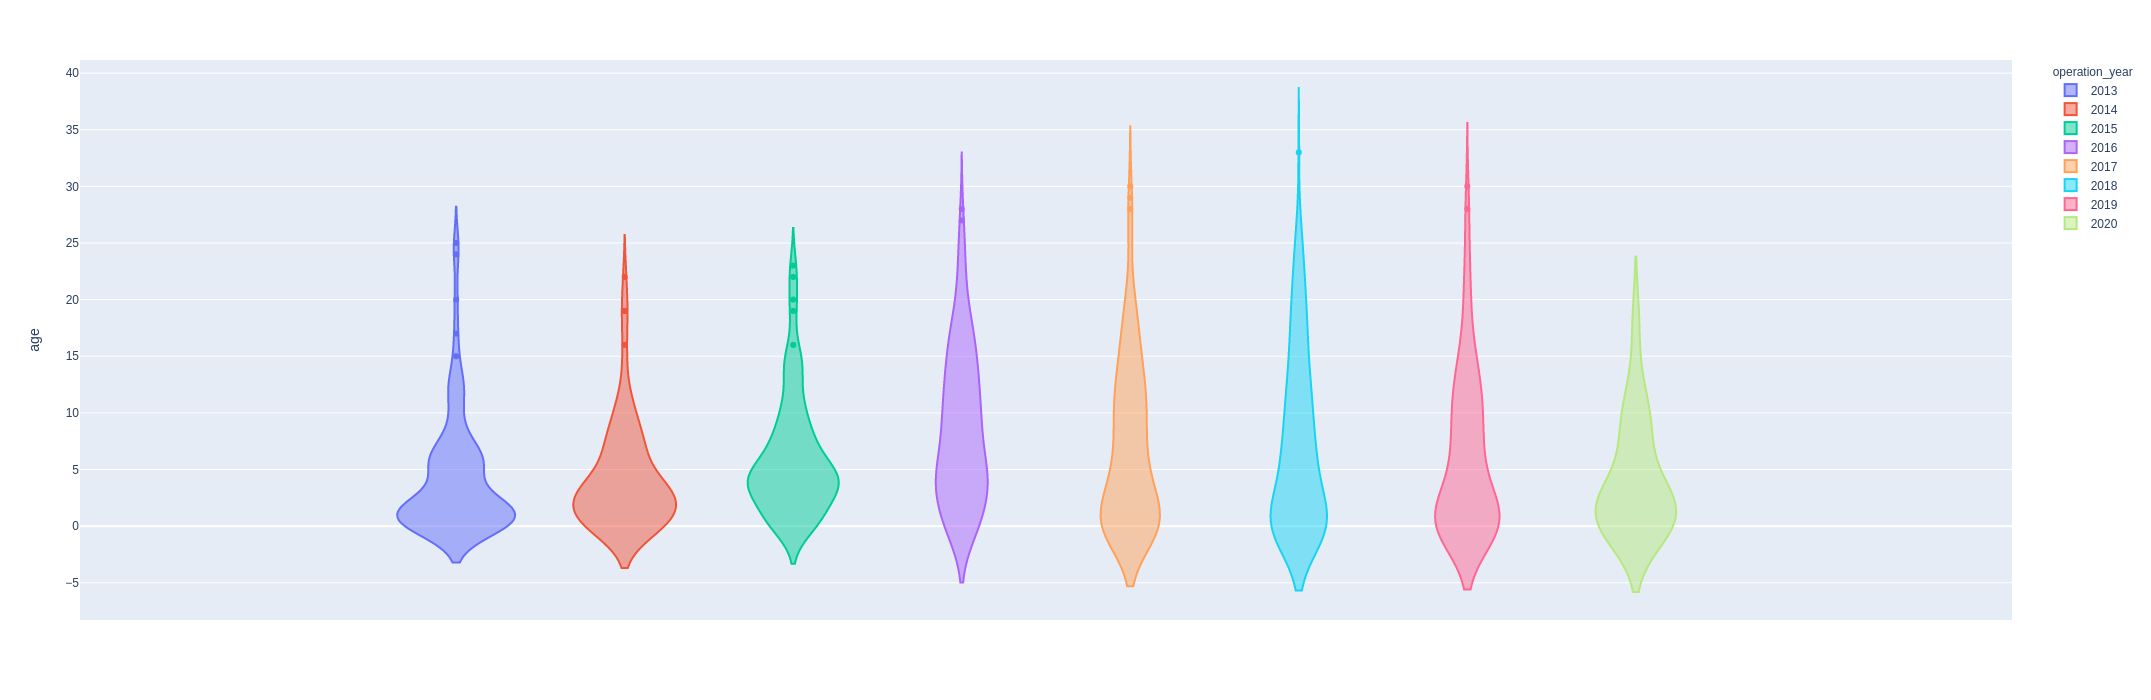

In [324]:
px.violin(tmp[['operation_year', 'age']].sample(1_000).sort_values('operation_year'), y='age', color='operation_year', height=700)

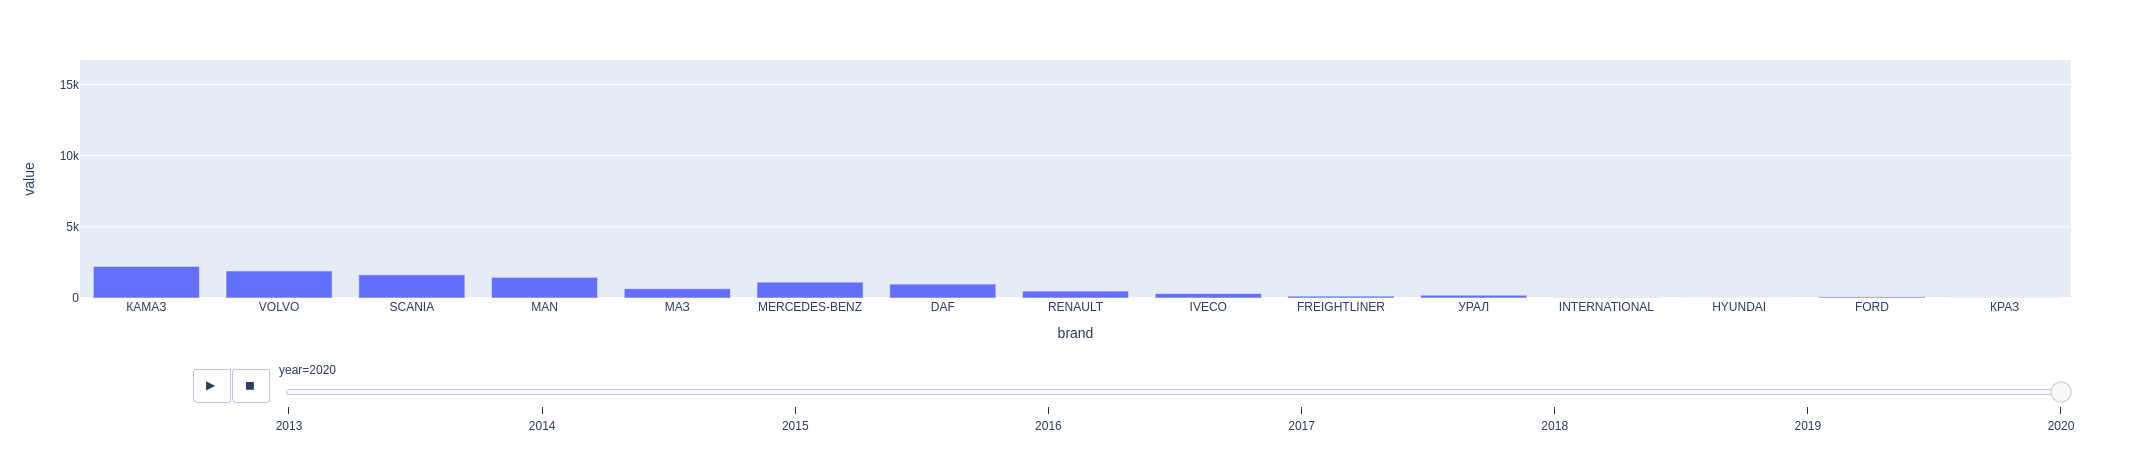

In [108]:
tr = get_transacation_count(tmp, 'operation_year', 'brand')

order = ['КАМАЗ',
 'VOLVO',
 'SCANIA',
 'MAN',
 'МАЗ',
 'MERCEDES-BENZ',
 'DAF',
 'RENAULT',
 'IVECO',
 'FREIGHTLINER',
 'УРАЛ',
 'INTERNATIONAL',
 'HYUNDAI',
 'FORD',
 'КРАЗ']

res = []

for year in range(2013, 2021):
    a = tr.loc[year].to_frame('value')
    a['year'] = year
    res.append(a.loc[order])
res = pd.concat(res, axis=0).reset_index()

px.bar(res,x='brand', y='value', animation_frame='year')

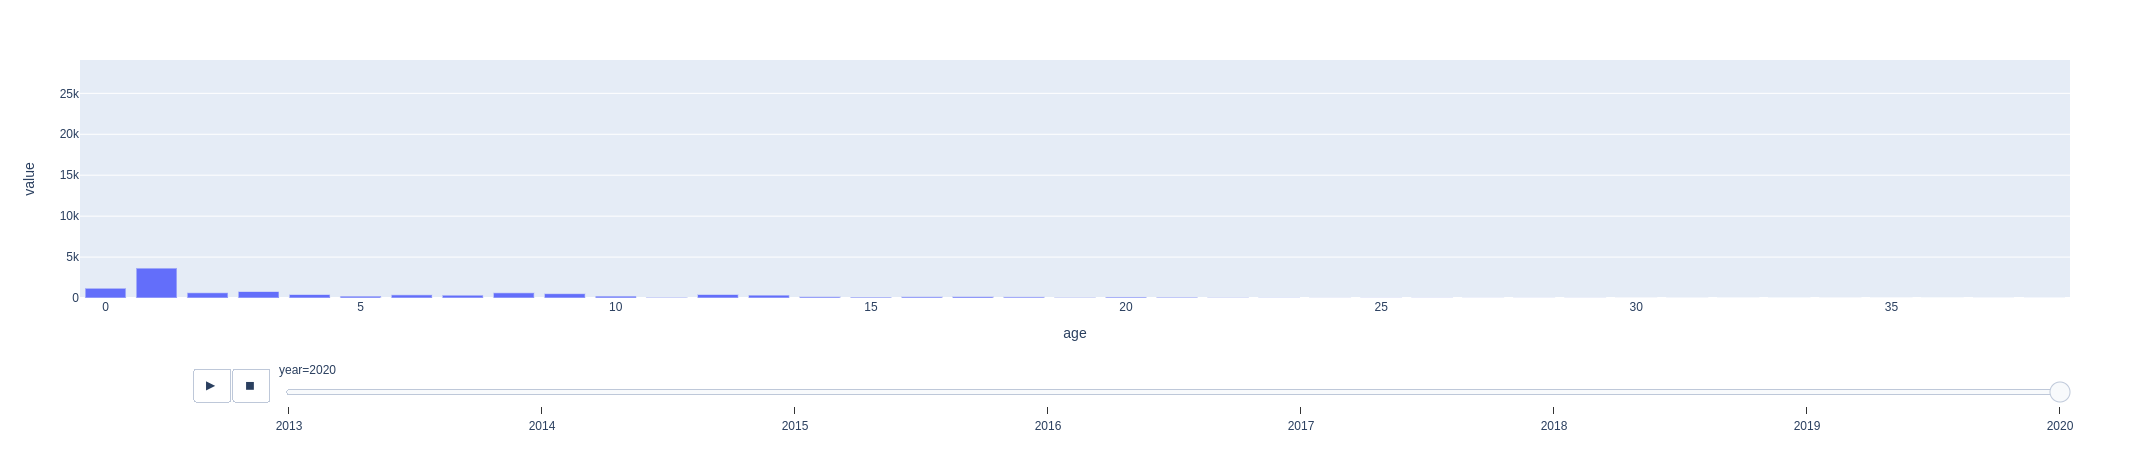

In [101]:
tr = get_transacation_count(tmp, 'operation_year', 'age')

res = []

for year in range(2013, 2021):
    a = tr.loc[year].to_frame('value')
    a['year'] = year
    res.append(a)
res = pd.concat(res, axis=0).reset_index()

px.bar(res,x='age', y='value', animation_frame='year')

In [109]:
tmp.groupby('operation_year')['brand'].agg(Counter).to_frame()

brand
operation_year                                                   
2013            {'DAF': 3491, 'КАМАЗ': 6480, 'IVECO': 2201, 'M...
2014            {'MERCEDES-BENZ': 3399, 'MAN': 5938, 'VOLVO': ...
2015            {'HYUNDAI': 169, 'КАМАЗ': 5108, 'SCANIA': 6049...
2016            {'КАМАЗ': 12899, 'DAF': 6679, 'SCANIA': 10834,...
2017            {'КАМАЗ': 15123, 'МАЗ': 9986, 'VOLVO': 15106, ...
2018            {'MERCEDES-BENZ': 8041, 'МАЗ': 7579, 'SCANIA':...
2019            {'КАМАЗ': 13928, 'МАЗ': 5881, 'IVECO': 2136, '...
2020            {'RENAULT': 488, 'VOLVO': 1901, 'MAN': 1455, '...

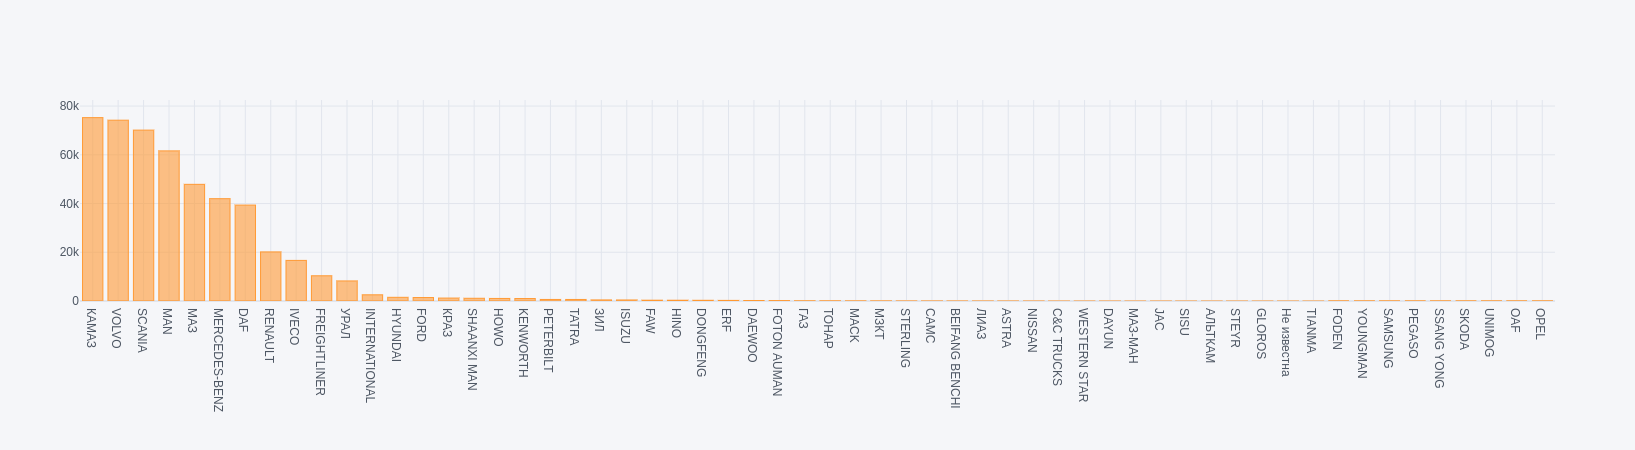

In [110]:
tmp['brand'].value_counts().iplot(kind='bar')

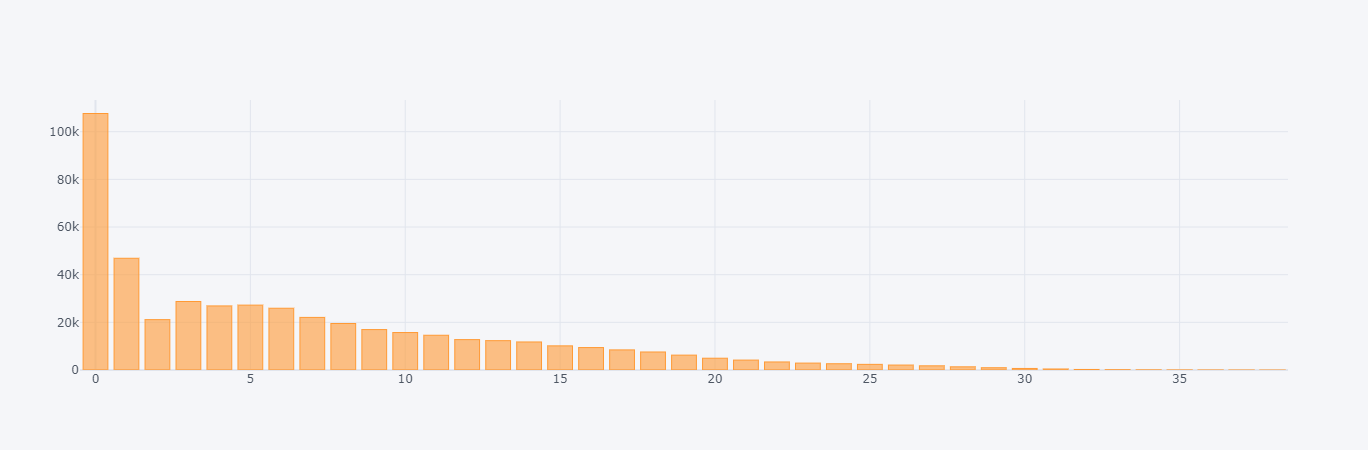

In [111]:
tmp['age'].value_counts().iplot(kind='bar')

In [272]:
sec = transaction_data.loc[transaction_data.groupby('vin')['inn_seller'].shift() == 'INITIAL']
sec.groupby('brand')['age'].agg(['count', 'mean', 'median']).query('count > 100').sort_values('count')[::-1]

count      mean  median
brand                                 
КАМАЗ          33821  2.753467     2.0
SCANIA          7689  2.958642     3.0
VOLVO           6730  3.135364     3.0
ГАЗ             5943  2.332324     2.0
MAN             5308  3.272231     3.0
MERCEDES-BENZ   4925  3.268223     3.0
МАЗ             4717  2.951452     3.0
HYUNDAI         3502  3.101656     3.0
УРАЛ            3318  3.015069     3.0
DAF             2654  3.145441     3.0
ISUZU           2451  2.614851     2.0
HINO            2092  3.152008     3.0
IVECO           1855  3.263073     3.0
SHAANXI MAN     1843  3.434075     3.0
MITSUBISHI      1279  2.806880     3.0
RENAULT          940  4.029787     4.0
FAW              505  3.487129     4.0
FOTON AUMAN      496  4.433468     5.0
DAEWOO           338  3.650888     3.0
HOWO             311  3.318328     3.0
DONGFENG         256  3.367188     3.0
ЗИЛ              191  4.937173     4.0
FORD             158  3.658228     3.0
CAMC             144  3.694444     4.0
XCMG             123  3.317073     3.0

In [114]:
tmp['size_buyer'].value_counts()

Микропредприятия       88659
Малые предприятия      73386
Крупные предприятия    67172
Средние предприятия    32046
Name: size_buyer, dtype: int64

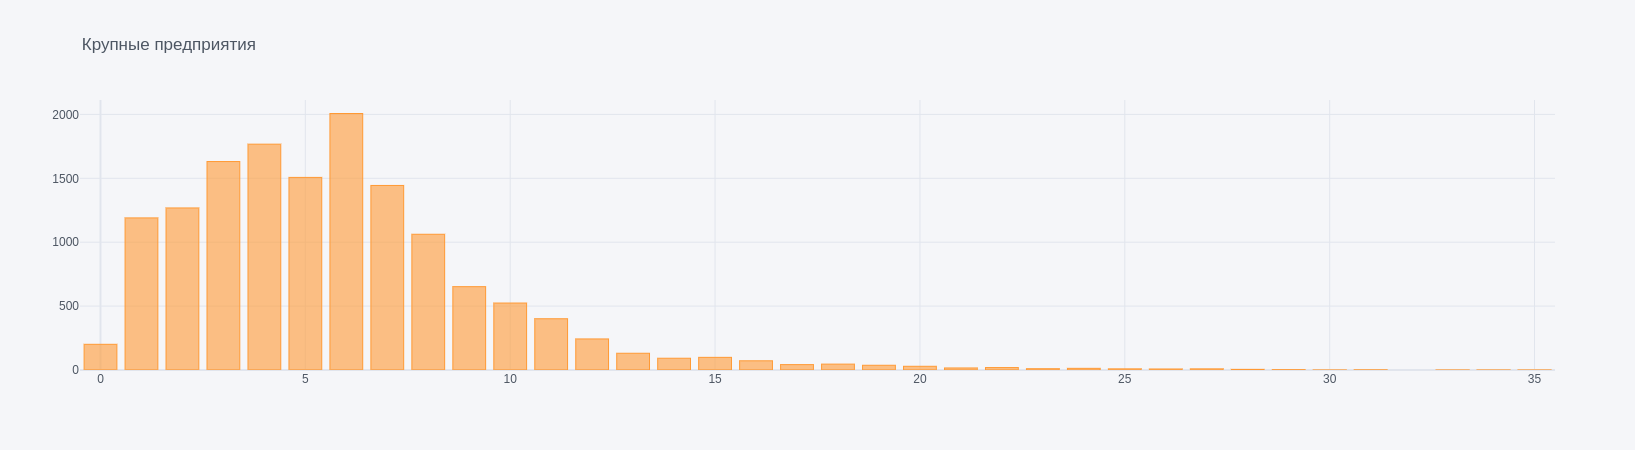

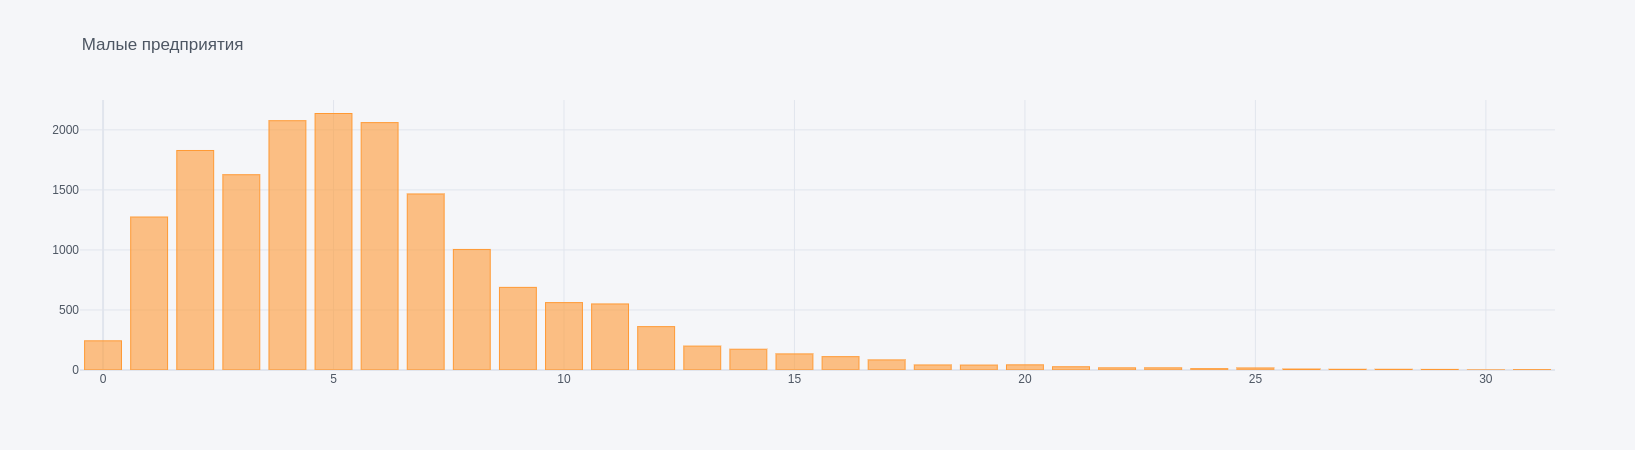

In [273]:
tmp.query("size_seller == 'Крупные предприятия'").sort_values('operation_date').groupby('vin')['age'].last().value_counts().iplot('bar', title='Крупные предприятия')
tmp.query("size_seller == 'Малые предприятия'").sort_values('operation_date').groupby('vin')['age'].last().value_counts().iplot('bar', title='Малые предприятия')


#['age'].value_counts().iplot('bar', title='Крупные предприятия')
#tmp.query("size_seller == 'Малые предприятия'")['age'].value_counts().iplot('bar', title='Малые предприятия')

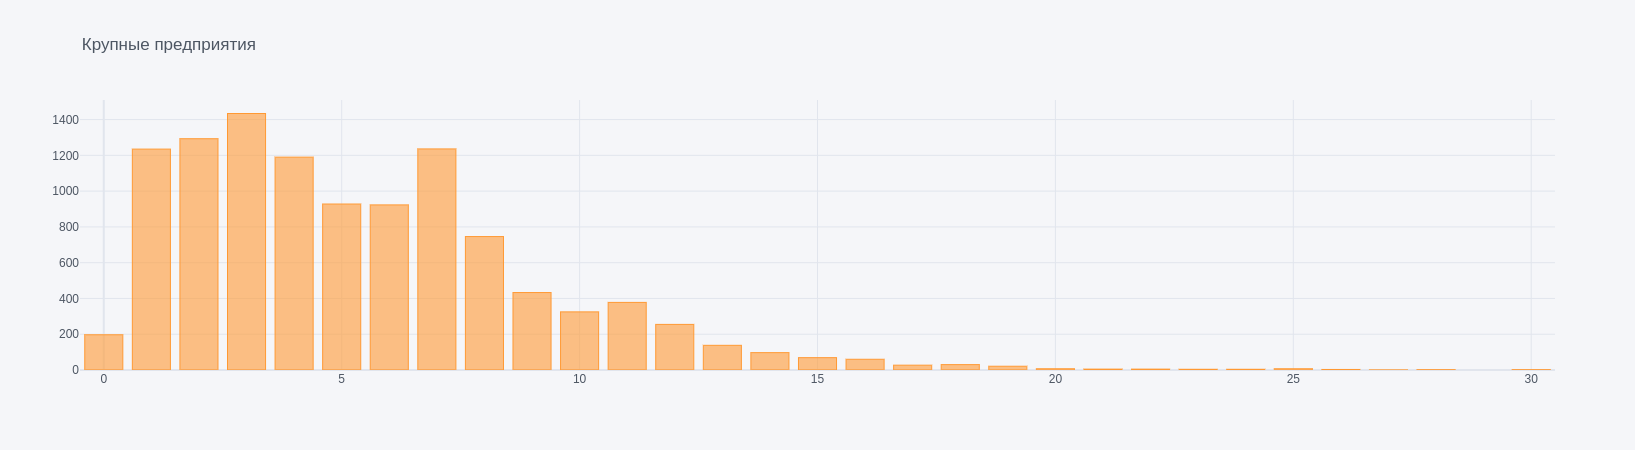

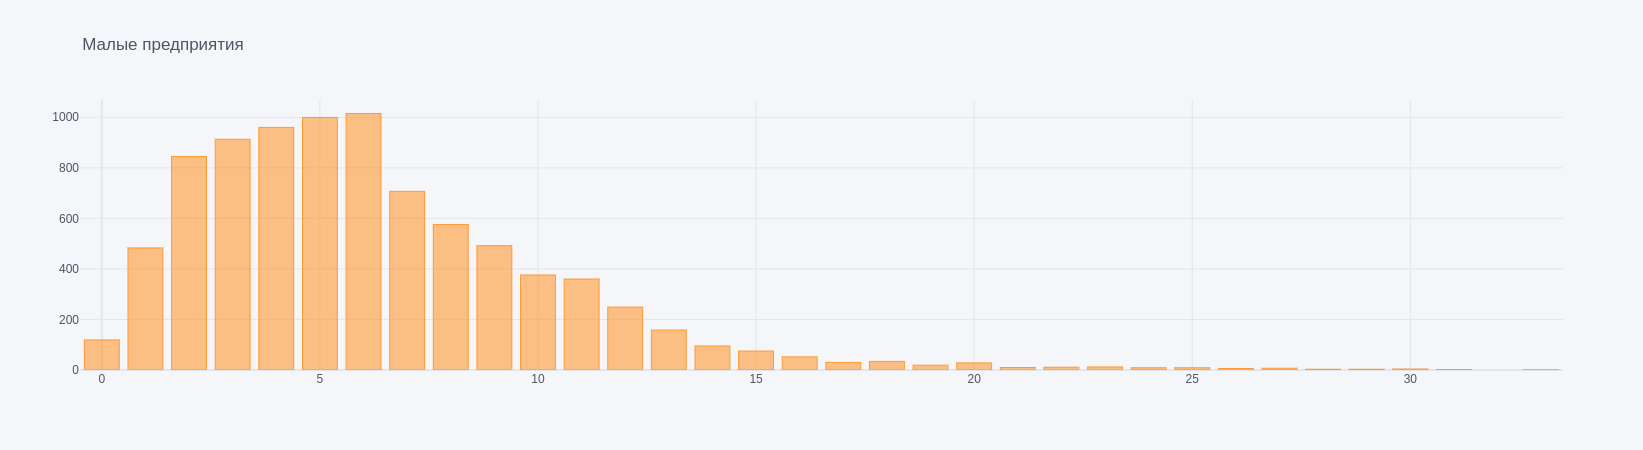

In [88]:
tmp.query("size_seller == 'Крупные предприятия'")['age'].value_counts().iplot('bar', title='Крупные предприятия')
tmp.query("size_seller == 'Малые предприятия'")['age'].value_counts().iplot('bar', title='Малые предприятия')

In [274]:
struct = tmp.query("size_seller == 'Крупные предприятия'").groupby('name_buyer').agg({
    'brand': Counter,
    'age': ['mean', Counter, 'count']
})

struct.columns = ['_'.join(col) for col in list(struct)]

In [275]:
struct.sort_values('age_count')[::-1].head(20)

brand_Counter  \
name_buyer                                                                                        
ФИЗ ЛИЦО                                      {'УРАЛ': 47, 'КАМАЗ': 401, 'MAN': 668, 'MERCED...   
5032099538                                                                         {'MAN': 300}   
ООО "ТЭМПО-ЛОГИСТИК"                                                   {'MAN': 1, 'КАМАЗ': 190}   
ООО "АЛМАЗДОРТРАНС"                                                 {'VOLVO': 154, 'КАМАЗ': 10}   
ООО "ИНТЕРАВТО"                                            {'МАЗ': 95, 'SCANIA': 34, 'MAN': 25}   
ООО "АГРО-АВТО"                                           {'SCANIA': 2, 'MAN': 2, 'КАМАЗ': 121}   
АО(Н) "ВОЛЬВО ВОСТОК"                         {'MAN': 2, 'VOLVO': 78, 'MERCEDES-BENZ': 8, 'R...   
ООО "ГК "Д-ТРАНС"                                                                   {'MAN': 88}   
ООО "ССТ"                                      {'ISUZU': 5, 'КАМАЗ': 64, 'SCANIA': 1, 'МАЗ': 3}   
ООО "СОЮЗ-ЛОГИСТИК"                                                               {'КАМАЗ': 73}   
ООО "АБИНСКИЙ ЭЛЕКТРОМЕТАЛЛУРГИЧЕСКИЙ ЗАВОД"                                    {'RENAULT': 70}   
ООО "РН-ТРАНСПОРТ"                            {'КАМАЗ': 46, 'УРАЛ': 11, 'КРАЗ': 2, 'RENAULT'...   
ООО "ФАВОРИТ ЛОГИСТИКА"                                                         {'HYUNDAI': 64}   
АО "ПИК-ИНДУСТРИЯ"                                                                  {'MAN': 63}   
ООО "РМК"                                                                         {'VOLVO': 60}   
ООО "СДО-ЛОГИСТИК"                                                                {'IVECO': 60}   
ООО " СТО 2000 "                                                                  {'IVECO': 55}   
ООО "МИРАТОРГ ЛОГИСТИК"                                       {'MERCEDES-BENZ': 50, 'IVECO': 1}   
ООО "БАШНЕФТЬ-РОЗНИЦА"                                    {'MAN': 18, 'КАМАЗ': 26, 'SCANIA': 5}   
ООО "ФЕСКО ТРАНС"                                                                 {'IVECO': 48}   

                                              age_mean  \
name_buyer                                               
ФИЗ ЛИЦО                                      7.367662   
5032099538                                    6.020000   
ООО "ТЭМПО-ЛОГИСТИК"                          2.214660   
ООО "АЛМАЗДОРТРАНС"                           7.286585   
ООО "ИНТЕРАВТО"                               7.389610   
ООО "АГРО-АВТО"                               1.112000   
АО(Н) "ВОЛЬВО ВОСТОК"                         4.308333   
ООО "ГК "Д-ТРАНС"                             5.931818   
ООО "ССТ"                                     4.054795   
ООО "СОЮЗ-ЛОГИСТИК"                           1.000000   
ООО "АБИНСКИЙ ЭЛЕКТРОМЕТАЛЛУРГИЧЕСКИЙ ЗАВОД"  4.071429   
ООО "РН-ТРАНСПОРТ"                            9.776119   
ООО "ФАВОРИТ ЛОГИСТИКА"                       2.937500   
АО "ПИК-ИНДУСТРИЯ"                            4.460317   
ООО "РМК"                                     3.000000   
ООО "СДО-ЛОГИСТИК"                            1.566667   
ООО " СТО 2000 "                              1.000000   
ООО "МИРАТОРГ ЛОГИСТИК"                       4.823529   
ООО "БАШНЕФТЬ-РОЗНИЦА"                        7.061224   
ООО "ФЕСКО ТРАНС"                             4.416667   

                                                                                    age_Counter  \
name_buyer                                                                                        
ФИЗ ЛИЦО                                      {11: 244, 16: 50, 8: 548, 3: 300, 5: 489, 13: ...   
5032099538                                                                      {4: 98, 7: 202}   
ООО "ТЭМПО-ЛОГИСТИК"                                                {9: 1, 2: 157, 3: 32, 4: 1}   
ООО "АЛМАЗДОРТРАНС"                           {10: 10, 4: 26, 11: 9, 2: 10, 18: 12, 15: 5, 5...   
ООО "ИНТЕРАВТО"                 

# STASH

In [ ]:
from collections import Counter
from tqdm.notebook import tqdm_notebook as tqdm

operation_reason = [
    'Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков',
    'первичная регистрация',
]

tmp = transaction_df.groupby('inn_buyer').agg({
    'vin':'nunique',
    'brand':Counter,
    'body_type':Counter,
})

tmp = tmp[tmp['vin'] > 50]

n_top = 3
column = 'brand'

res = []
for row in tqdm(tmp.iterrows()):
    inn = row[0]
    a = row[1][column]
    counter = pd.DataFrame(a.values(), a.keys(), columns=[inn]).sort_values(inn)[::-1][:n_top]
    res.append(pd.concat((
        pd.DataFrame(counter.values, index=['top'+str(col+1)+'_'+column+'_value' for col in range(min(n_top, len(counter)))], columns=[inn]).T,
        pd.DataFrame(counter.index, index=['top'+str(col+1)+'_'+column+'_name' for col in range(min(n_top, len(counter)))], columns=[inn]).T
    ), axis=1))

# SALE AGE PREDICTION

Подходы:
  1. прогнозировать через сколько лет будет перепродана машина
  2. угадывать будет ли машина продана в этом году

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import LabelEncoder

from collections import defaultdict

import seaborn as sns

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def union_minor(series, thresh):
    series = series.copy()
    valid_list = series.value_counts().to_frame('data').query('data < @thresh').index
    series.loc[series.isin(valid_list)] = 'MINOR'
    return series

In [9]:
tmp = (transaction_data['inn_seller'] == 'INITIAL').groupby(transaction_data['vin']).sum()
vin_list = tmp[tmp == 1].index.tolist()

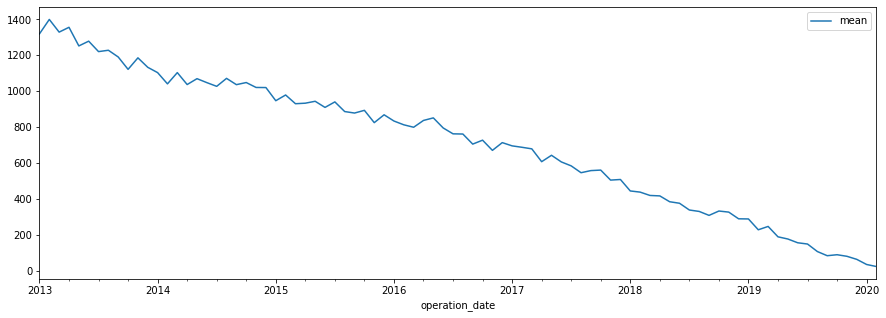

In [12]:
X_orig.set_index('operation_date').resample('1M')['age'].agg(['mean']).plot(figsize=(15,5))

In [13]:
X_orig

inn_seller   inn_buyer        region_seller  \
vin                                                              
X89385810C0BW1038  6165154243  6165031467   Ростовская область   
X89282027C0CV8007  7710474791  7734597400               Москва   
X89282027C0CV8008  7710474791  7734597400               Москва   
XUH279570C0000070  3508005572  3508007918  Вологодская область   
XTC652000C1259908  7704221591  3111005472               Москва   
...                       ...         ...                  ...   
XZ845717RK4000072  4004018630  4027142218    Самарская область   
WMA24XZZ8JM797005  5504135133  5404084044       Омская область   
WMA24XZZ3JM796876  5504135133  5404084044       Омская область   
9BSR4X20003891254  1639043296  3702729720            Татарстан   
LZGJRDR44HX127157  0264066195  1650314976         Башкортостан   

                    activity_field_seller           region_buyer  \
vin                                                                
X89385810C0BW1038                    None     Ростовская область   
X89282027C0CV8007                    None                 Москва   
X89282027C0CV8008                    None                 Москва   
XUH279570C0000070                 Пищевая    Вологодская область   
XTC652000C1259908     Лизинговая компания   Белгородская область   
...                                   ...                    ...   
XZ845717RK4000072     Нефтегазодобывающая      Самарская область   
WMA24XZZ8JM797005  Коммерческие перевозки  Новосибирская область   
WMA24XZZ3JM796876  Коммерческие перевозки  Новосибирская область   
9BSR4X20003891254  Коммерческие перевозки     Ивановская область   
LZGJRDR44HX127157            Строительная           Башкортостан   

                  activity_field_buyer        brand chassis_config    year  \
vin                                                                          
X89385810C0BW1038                 None        КАМАЗ            6x6  2012.0   
X89282027C0CV8007                  МЧС        IVECO            4x2  2012.0   
X89282027C0CV8008                  МЧС        IVECO            4x2  2012.0   
XUH279570C0000070                 None          МАЗ            4x2  2012.0   
XTC652000C1259908  Лизинговая компания        КАМАЗ            6x4  2012.0   
...                                ...          ...            ...     ...   
XZ845717RK4000072                 None        КАМАЗ            6x6  2019.0   
WMA24XZZ8JM797005                 None          MAN            6x2  2018.0   
WMA24XZZ3JM796876                 None          MAN            6x2  2018.0   
9BSR4X20003891254                 None       SCANIA            4x2  2016.0   
LZGJRDR44HX127157                 None  SHAANXI MAN            6x4  2017.0   

                         body_type   model   age operation_date  \
vin                                                               
X89385810C0BW1038           Фургон   43114    20     2013-01-19   
X89282027C0CV8007  Грузовые прочие    100E    22     2013-01-23   
X89282027C0CV8008  Грузовые прочие    100E    22     2013-01-23   
XUH279570C0000070           Фургон    5336    42     2013-01-15   
XTC652000C1259908         Самосвал    6520    40     2013-01-18   
...                            ...     ...   ...            ...   
XZ845717RK4000072         Автокран   43118   367     2019-03-30   
WMA24XZZ8JM797005  Тягач седельный  26.400   571     2018-09-07   
WMA24XZZ3JM796876  Тягач седельный  26.440   571     2018-09-07   
9BSR4X20003891254  Тягач седельный  R440LA  1301     2016-09-07   
LZGJRDR44HX127157         Самосвал  SX3256   802     2018-01-19   

                                                    operation_reason  \
vin                                                                    
X89385810C0BW1038  Изменение собственника по сделкам, произведенн...   
X89282027C0CV8007  Изменение собственника по сделкам, произведенн...   
X89282027C0CV8008  Изменение собственника по сделкам, произведенн...   
XUH279570C0000070  Изменение

In [10]:
OPERATION_REASONS = [
    'Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков',
    'Изменение собственника по сделкам, произведенным в любой форме (купля-продажа, дарение, др.) с заменой  государственных регистрационных знаков'
]

FEATURES = [
    'inn_seller',
    'region_seller',
    'activity_field_seller',
    'size_seller',
    'name_seller',
    'activity_seller',
    'status_seller',
    'activity_code_seller',
    'risk_seller',
    'group_seller',
    'upper_activity_seller',
    
    'brand',
    'chassis_config',
#     'year',
    'body_type',
    'model',
    
    'operation_year',
    'operation_month',
    'operation_day',
    
    'primary_age',
]

TARGET = 'age'

#################################

X_orig = transaction_data.loc[transaction_data['vin'].isin(vin_list)]
tmp = X_orig.groupby('vin')[['operation_date', 'inn_seller']].shift()
operation_date = tmp.loc[tmp['inn_seller'] == 'INITIAL', 'operation_date']
X_orig = X_orig.loc[X_orig.groupby('vin')['inn_seller'].shift() == 'INITIAL']
X_orig['age'] = (X_orig['operation_date'] - operation_date ).dt.days
X_orig['operation_date'] = operation_date
X_orig = X_orig.loc[X_orig['operation_reason'].isin(OPERATION_REASONS)].set_index('vin')

X_orig['operation_year'] = X_orig['operation_date'].dt.year
X_orig['operation_month'] = X_orig['operation_date'].dt.month
X_orig['operation_day'] = X_orig['operation_date'].dt.day

X_orig['primary_age'] = X_orig['operation_year'] - X_orig['year']
# X_orig['year'] = X_orig['year'].clip(2005)

In [339]:
# MAX_AGE = 10
# X_orig = X_orig.loc[X_orig['age'] < MAX_AGE]
y = X_orig[TARGET]
X_orig = X_orig[FEATURES]

cat_features = X_orig.dtypes[X_orig.dtypes == 'object'].index

In [340]:
X_pred = transaction_data.loc[transaction_data['inn_seller'] == 'INITIAL']
X_pred.set_index('vin', inplace=True)

X_pred[[
    'inn_seller',
    'region_seller',
    'activity_field_seller',
    'size_seller',
    'name_seller',
    'activity_seller',
    'status_seller',
    'activity_code_seller',
    'risk_seller',
    'group_seller',
    'upper_activity_seller',
]] =\
X_pred[[
    'inn_buyer',
    'region_buyer',
    'activity_field_buyer',
    'size_buyer',
    'name_buyer',
    'activity_buyer',
    'status_buyer',
    'activity_code_buyer',
    'risk_buyer',
    'group_buyer',
    'upper_activity_buyer',

]]

X_pred['operation_year'] = X_pred['operation_date'].dt.year
X_pred['operation_month'] = X_pred['operation_date'].dt.month
X_pred['operation_day'] = X_pred['operation_date'].dt.day

X_pred['primary_age'] = X_pred['operation_year'] - X_pred['year']

X_pred = X_pred[FEATURES]

X_pred.drop_duplicates(inplace=True)
X_pred[cat_features] = X_pred[cat_features].fillna('NaN').astype('category')

year_pred = X_pred['operation_year']
X_pred.drop('operation_year', axis=1, inplace=True)

In [341]:
# X_orig['inn_seller'] = union_minor(X_orig['inn_seller'], 10)
# X_orig['activity_field_seller'] = union_minor(X_orig['activity_field_seller'], 100)
# X_orig['name_seller'] = union_minor(X_orig['name_seller'], 100)
# X_orig['activity_seller'] = union_minor(X_orig['activity_seller'], 10)
# X_orig['group_seller'] = union_minor(X_orig['group_seller'], 10)
# X_orig['brand'] = union_minor(X_orig['brand'], 10)
# X_orig['body_type'] = union_minor(X_orig['body_type'], 10)
# X_orig['model'] = union_minor(X_orig['model'], 10)

vin
X89385810C0BW1038    False
X89282027C0CV8007    False
X89282027C0CV8008    False
XUH279570C0000070    False
XTC652000C1259908    False
                     ...  
XZ845717RK4000072     True
WMA24XZZ8JM797005     True
WMA24XZZ3JM796876     True
9BSR4X20003891254    False
LZGJRDR44HX127157     True
Name: operation_year, Length: 79919, dtype: bool

In [498]:
year_train.max()

2020

In [501]:
try:
    X_orig[cat_features] = X_orig[cat_features].fillna('NaN').astype('category')
except:
    pass


MAX_YEAR = 2018
mask = X_orig['operation_year'] <= MAX_YEAR
X_train, X_test, y_train, y_test = train_test_split(X_orig.loc[mask], y.loc[mask], test_size=0.1)

# TRAIN_MAX_YEAR = 2017
# TEST_MAX_YEAR = 2020
# train_mask = X_orig['operation_year'] <= TRAIN_MAX_YEAR
# test_mask = ~train_mask & (X_orig['operation_year'] <= TEST_MAX_YEAR)
# X_train, X_test = X_orig.loc[train_mask], X_orig.loc[test_mask]
# y_train, y_test = y.loc[train_mask], y.loc[test_mask]

year_train = X_train['operation_year']
X_train.drop('operation_year', axis=1, inplace=True)

year_test = X_test['operation_year']
X_test.drop('operation_year', axis=1, inplace=True)

# X_train.shape, X_test.shape

In [502]:
print(y_train.mean(), y_train.std())
print(y_test.mean(), y_test.std())

901.9115594919406 551.834519066383
908.4427216811891 551.7704987126401


In [344]:
# le_dict = {}
# for col in cat_features:
#     le = LabelEncoder()
#     X_orig[col] = X_orig[col].cat.add_categories('NONE')
#     X_train[col] = X_train[col].cat.add_categories('NONE')
#     X_test[col] = X_test[col].cat.add_categories('NONE')
    
#     le.fit(X_orig[col].fillna('NONE'))
#     X_train[col] = le.transform(X_train[col].fillna('NONE'))
#     X_test[col] = le.transform(X_test[col].fillna('NONE'))
#     le_dict[col] = le

In [345]:
X = X_orig.copy()
X['age'] = y

In [169]:
tmp = (X.groupby('operation_year')['age'].agg(['mean', 'median', 'std'])/365).reset_index()
tmp['mean'], tmp['median'] = tmp['mean'] + tmp['operation_year'], tmp['median'] + tmp['operation_year']
tmp

operation_year         mean       median       std
0            2013  2016.375667  2016.202740  1.739854
1            2014  2016.885296  2016.898630  1.504994
2            2015  2017.504869  2017.605479  1.331945
3            2016  2018.094304  2018.131507  1.016421
4            2017  2018.614570  2018.649315  0.721743
5            2018  2019.020686  2019.052055  0.519895
6            2019  2019.510343  2019.473973  0.310764
7            2020  2020.092237  2020.076712  0.051699

In [18]:
tmp = X.groupby('year')['age'].agg(['mean', 'median', 'count']).sort_index()
tmp[['mean', 'median']] = tmp[['mean', 'median']]/365
tmp

mean    median  count
year                             
2005.0  2.549146  2.264384    130
2006.0  2.336192  2.190411    100
2007.0  2.712273  2.819178    246
2008.0  2.359179  2.136986    249
2009.0  2.380372  2.145205    128
2010.0  3.020613  3.101370    441
2011.0  3.117714  2.960274    992
2012.0  3.392141  3.167123   5836
2013.0  2.993737  2.947945  20862
2014.0  2.796835  2.849315  15504
2015.0  2.450146  2.564384   8412
2016.0  2.016582  2.039726   8666
2017.0  1.524311  1.542466  12162
2018.0  0.923731  0.964384   5114
2019.0  0.368390  0.282192   1073
2020.0  0.061644  0.060274      4

In [1]:
X_train

NameError: name 'X_train' is not defined

In [ ]:
%%time
# model = RandomForestRegressor(n_estimators=500)
# model = LinearRegression()
# model = XGBRegressor(n_estimators=10_000, subsample=0.7, learning_rate=0.01)
# model = LGBMRegressor(n_estimators=100_000, learning_rate=0.01, subsample=0.3)
model = CatBoostRegressor(cat_features=cat_features, n_estimators=100_000, learning_rate=0.01, loss_function='MAE', subsample=0.9)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=50)
# model.fit(X_train, y_train)

# print(model.score(X_test, y_test))

0:	learn: 445.3100134	test: 446.4226336	best: 446.4226336 (0)	total: 55.6ms	remaining: 1h 32m 38s
50:	learn: 392.3716919	test: 380.2320296	best: 380.2320296 (50)	total: 1.82s	remaining: 59m 34s
100:	learn: 368.6855329	test: 350.8816530	best: 350.8816530 (100)	total: 3.43s	remaining: 56m 29s
150:	learn: 357.8767678	test: 338.6678065	best: 338.6678065 (150)	total: 6.03s	remaining: 1h 6m 26s
200:	learn: 350.5942151	test: 330.6017543	best: 330.6017543 (200)	total: 8.33s	remaining: 1h 8m 54s
250:	learn: 345.0709949	test: 324.4861855	best: 324.4861855 (250)	total: 10.7s	remaining: 1h 10m 59s
300:	learn: 341.7027593	test: 321.0798515	best: 321.0798515 (300)	total: 13.4s	remaining: 1h 13m 49s
350:	learn: 339.0875174	test: 318.4379328	best: 318.4379328 (350)	total: 16.3s	remaining: 1h 17m 17s
400:	learn: 336.6305314	test: 315.9800798	best: 315.9800798 (400)	total: 19.3s	remaining: 1h 19m 54s
450:	learn: 334.4702953	test: 313.8007522	best: 313.8007522 (450)	total: 22.2s	remaining: 1h 21m 46s
500

In [368]:
# %%time
# model_1 = XGBRegressor(n_estimators=3000, max_depth=5)
# model_1.fit(X_train, y_train, )
# model_1.score(X_test, y_test)

In [683]:
model.best_iteration_

42588

In [684]:
y_pred = model.predict(X_train)/365
y_true = y_train/365

print(y_pred.mean(), y_true.mean())

2.379003288186539 2.4709905739505285


In [685]:
y_pred = model.predict(X_test)/365
y_true = y_test/365

print(y_pred.mean(), y_true.mean())

2.3802011790132465 2.4888841689895567


In [486]:
y_pred = np.ones_like(y_test)*y_test.mean()/365
y_true = y_test/365

print(y_pred.mean(), y_true.mean())

2.421822850247508 2.421822850247506


In [686]:
print(mean_absolute_error(y_pred, y_true))
print(r2_score(y_true, y_pred))

0.7196257730718583
0.5396462441146271


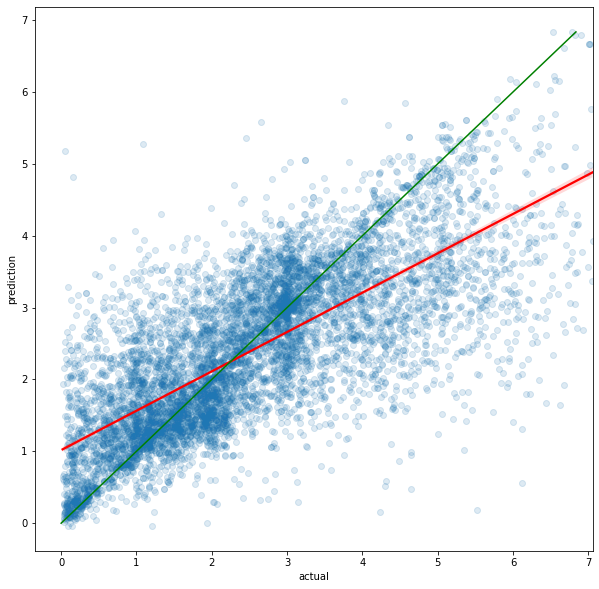

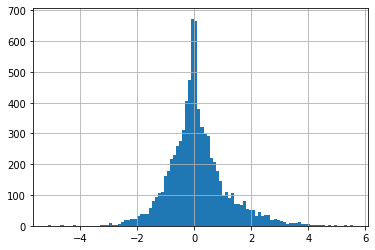

In [687]:
import matplotlib.pyplot as plt

MAX_AGE = np.min((np.max(y_true), np.max(y_pred)))
plt.figure(figsize=(10,10))
sns.regplot(x=y_true, y=y_pred, line_kws={"color": "red"}, scatter_kws={"alpha": 0.1})
plt.scatter(y_true, y_pred, alpha=0.05)
plt.plot([0, MAX_AGE], [0,MAX_AGE], color='green')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.show()

(y_true - y_pred).hist(bins=100)
plt.show()

In [826]:
result = X_pred.copy()
result['pred_age'] = model.predict(X_pred)/365
result['operation_year'] = year_pred
result['pred_resale_year'] = result['pred_age'] + result['operation_year']

In [827]:
result['N'] = np.arange(len(result))
N = pd.merge(result.reset_index(), X_orig.reset_index()[['vin', 'inn_seller']], on=['vin', 'inn_seller'], how='inner')['N'].tolist()
result = result.loc[~result['N'].isin(N)].drop('N', axis=1).reset_index()
del N

In [828]:
kamaz_result = result.loc[result['brand'] == 'КАМАЗ'].loc[(result['pred_resale_year'] > 2020.5) & (result['pred_resale_year'] < 2022)].sort_values('pred_resale_year')

In [838]:
tmp = kamaz_result.groupby('inn_seller')[['pred_resale_year', 'operation_year']].agg(['mean', 'median', 'count']).dropna()[::-1]
tmp.columns = ['_'.join(col) for col in tmp.columns]
pred_resale = tmp.drop('pred_resale_year_count', axis=1).sort_values('operation_year_count')[::-1]
inn_list = pred_resale.query('10 <= operation_year_count < 100').index

In [839]:
pred_resale

pred_resale_year_mean  pred_resale_year_median  \
inn_seller                                                   
ФИЗ ЛИЦО              2020.732858              2020.698404   
8602060555            2021.180079              2021.138583   
7708503727            2021.074091              2021.051311   
8622000931            2021.295508              2021.242804   
7701754640            2020.909018              2020.891344   
...                           ...                      ...   
4246003129            2021.701336              2021.701336   
4246001650            2021.360570              2021.360570   
4243001483            2020.928279              2020.928279   
4241002280            2020.851836              2020.851836   
5247054209            2021.085669              2021.085669   

            operation_year_mean  operation_year_median  operation_year_count  
inn_seller                                                                    
ФИЗ ЛИЦО            2018.982877                 2019.0                   876  
8602060555          2018.945736                 2019.0                   129  
7708503727          2019.000000                 2019.0                    87  
8622000931          2019.000000                 2019.0                    68  
7701754640          2019.000000                 2019.0                    63  
...                         ...                    ...                   ...  
4246003129          2019.000000                 2019.0                     1  
4246001650          2019.000000                 2019.0                     1  
4243001483          2019.000000                 2019.0                     1  
4241002280          2019.000000                 2019.0                     1  
5247054209          2019.000000                 2019.0                     1  

[9312 rows x 5 columns]

In [840]:
kamaz_result

vin  inn_seller        region_seller  \
162561  XTC652005C0000766  0274170131         Башкортостан   
219845  X5J57652AL0000125    ФИЗ ЛИЦО               Москва   
106414  XTC652204H1356361  6317024749    Самарская область   
195589  X89422612K0DA8062  7718607570  Ханты-Мансийский АО   
204817  X897078L2K0FP0011  3812069957    Иркутская область   
...                   ...         ...                  ...   
229529  Z96780827L0000139  7805020789      Санкт-Петербург   
177231  X89552900J0EC2183  4603008857      Курская область   
198939  XTC658065J2512473  7203175930    Тюменская область   
199582  XKV336947K0000053  6452104341  Саратовская область   
190636  XTC651155K1399484  3827001711    Иркутская область   

       activity_field_seller          size_seller               name_seller  \
162561          Строительная    Малые предприятия  ООО "СТРОЙМЕХАНИЗАЦИЯ-2"   
219845              ФИЗ ЛИЦО                  NaN                  ФИЗ ЛИЦО   
106414          Нефтегазовая  Крупные предприятия  АО "ТРАНСНЕФТЬ-ПРИВОЛГА"   
195589   Нефтегазодобывающая  Крупные предприятия        ООО "ПАКЕР СЕРВИС"   
204817        Энергетическая    Малые предприятия         ООО "ЭНЕРГОЛИНИЯ"   
...                      ...                  ...                       ...   
229529                   NaN  Крупные предприятия         ЗАО "ЭЛЕКТРОТЯГА"   
177231    Сельское хозяйство    Малые предприятия             ООО "РАССВЕТ"   
198939          Строительная  Крупные предприятия                АО "ТОДЭП"   
199582          Строительная     Микропредприятия         ООО "СК ТРИАЛЕТИ"   
190636          Строительная    Малые предприятия           ООО РСП "ТОПКА"   

                                          activity_seller   status_seller  \
162561  Деятельность автомобильного грузового транспор...     Действующая   
219845                                                NaN             NaN   
106414  Транспортирование по трубопроводам нефти и неф...     Действующая   
195589  Предоставление услуг в области добычи нефти и ...     Действующая   
204817                Производство электромонтажных работ     Действующая   
...                                                   ...             ...   
229529  Производство аккумуляторов, в том числе для ав...     Действующая   
177231                       Выращивание зерновых культур     Действующая   
198939  Строительство автомобильных дорог и автомагист...  Реорганизуется   
199582               Строительство жилых и нежилых зданий     Действующая   
190636  Строительство автомобильных дорог и автомагист...     Действующая   

       activity_code_seller  risk_seller  \
162561                 49.4  Низкий риск   
219845                  NaN          NaN   
106414              49.50.1  Низкий риск   
195589                 09.1  Низкий риск   
204817                43.21  Низкий риск   
...                     ...          ...   
229529              27.20.2  Низкий риск   
177231              01.11.1  Низкий риск   
198939                42.11  Низкий риск   
199582                41.20  Низкий риск   
190636                42.11  Низкий риск   

                                             group_seller  \
162561                           ООО "СТРОЙМЕХАНИЗАЦИЯ-2"   
219845                                           ФИЗ ЛИЦО   
106414                           АО "ТРАНСНЕФТЬ-ПРИВОЛГА"   
195589                                 ООО "ПАКЕР СЕРВИС"   
204817                                  ООО "ЭНЕРГОЛИНИЯ"   
...                                                   ...   
229529                                  ЗАО "ЭЛЕКТРОТЯГА"   
177231                                      ООО "РАССВЕТ"   
198939  ДЕПАРТАМЕНТ ИМУЩЕСТВЕННЫХ ОТНОШЕНИЙ ТЮМЕНСКОЙ ...   
199582                                  ООО "СК ТРИАЛЕТИ"   
190636                                    ООО РСП "ТОПКА"   

                                    upper_activity_seller  brand  \
162561  Деятельность сухопутного и трубопроводного тра...  КАМАЗ   
21984

In [841]:
kamaz_result = kamaz_result.loc[kamaz_result['inn_seller'].isin(inn_list)]

In [843]:
N_BODY_TYPE = 50
top_body_type = kamaz_result['body_type'].value_counts().head(N_BODY_TYPE).index

kamaz_result['body_type_tmp'] = kamaz_result['body_type'].astype(str)
kamaz_result.loc[~kamaz_result['body_type'].isin(top_body_type), 'body_type_tmp'] = 'MINOR'

In [863]:
pd.get_dummies(kamaz_result['body_type_tmp']).groupby(kamaz_result['inn_seller'].astype(str)).sum().sum(axis=1).sort_values()

inn_seller
6162015019    10
6350012331    10
3329000602    10
1658029057    10
5321140070    10
              ..
7706660065    51
5003028028    60
7701754640    63
8622000931    68
7708503727    87
Length: 198, dtype: int64

In [864]:
tmp_mean = pd.get_dummies(kamaz_result['body_type_tmp']).groupby(kamaz_result['inn_seller'].astype(str)).mean()
tmp_sum = pd.get_dummies(kamaz_result['body_type_tmp']).groupby(kamaz_result['inn_seller'].astype(str)).sum()

In [865]:
top_body_type = tmp_sum.sum().sort_values()[::-1][:10].index.tolist()
tmp_mean = tmp_mean[top_body_type]
tmp_mean['Total'] = tmp_sum.sum(axis=1)
tmp_mean = tmp_mean.sort_values('Total')[::-1]

In [866]:
tmp_mean

Тягач седельный  Самосвал  Мусоровоз  Автокран  \
inn_seller                                                   
7708503727         0.000000  0.114943   0.000000  0.000000   
8622000931         0.014706  0.000000   0.073529  0.073529   
7701754640         1.000000  0.000000   0.000000  0.000000   
5003028028         0.216667  0.233333   0.066667  0.083333   
7706660065         0.000000  0.000000   0.000000  0.000000   
...                     ...       ...        ...       ...   
5321140070         0.000000  0.600000   0.000000  0.000000   
1658029057         0.600000  0.400000   0.000000  0.000000   
3329000602         0.100000  0.000000   0.000000  0.000000   
6350012331         0.100000  0.100000   0.000000  0.100000   
6162015019         0.000000  0.100000   0.000000  0.000000   

            Комбинированная дорожная машина  Автомастерская  Бортовой с КМУ  \
inn_seller                                                                    
7708503727                         0.000000        0.563218        0.137931   
8622000931                         0.014706        0.205882        0.102941   
7701754640                         0.000000        0.000000        0.000000   
5003028028                         0.000000        0.000000        0.000000   
7706660065                         0.000000        0.000000        0.000000   
...                                     ...             ...             ...   
5321140070                         0.000000        0.000000        0.400000   
1658029057                         0.000000        0.000000        0.000000   
3329000602                         0.900000        0.000000        0.000000   
6350012331                         0.000000        0.100000        0.000000   
6162015019                         0.100000        0.000000        0.000000   

            Автотопливозаправщик  Вахтовый автобус  Бортовой  Total  
inn_seller                                                           
7708503727                   0.0          0.068966  0.034483     87  
8622000931                   0.0          0.102941  0.117647     68  
7701754640                   0.0          0.000000  0.000000     63  
5003028028                   0.0          0.033333  0.283333     60  
7706660065                   0.0          0.000000  0.000000     51  
...                          ...               ...       ...    ...  
5321140070                   0.0          0.000000  0.000000     10  
1658029057                   0.0          0.000000  0.000000     10  
3329000602                   0.0          0.000000  0.000000     10  
6350012331                   0.1          0.100000  0.100000     10  
6162015019                   0.0          0.000000  0.000000     10  

[198 rows x 11 columns]

In [877]:
pred_resale[['pred_resale_year_mean']].merge(tmp_mean, left_index=True, right_index=True).rename({'pred_resale_year_mean':'pred_mean_year'}, axis=1).merge(inn_info, left_index=True, right_index=True, how='left').columns#.to_excel('../reports/data/pred_update_kamaz_carprak.xlsx')

Index(['pred_mean_year', 'Тягач седельный', 'Самосвал', 'Мусоровоз',
       'Автокран', 'Комбинированная дорожная машина', 'Автомастерская',
       'Бортовой с КМУ', 'Автотопливозаправщик', 'Вахтовый автобус',
       'Бортовой', 'Total', 'size', 'name', 'activity', 'status',
       'activity_code', 'risk', 'group', 'upper_activity'],
      dtype='object')

In [874]:
inn_info

size  \
inn                               
0100000050                 None   
0101000776  Крупные предприятия   
0101000832     Микропредприятия   
0101001787    Малые предприятия   
0101001963                 None   
...                         ...   
9909429160                 None   
9909446134                 None   
9909457263                 None   
9909461693                 None   
9909474692                 None   

                                                         name  \
inn                                                             
0100000050                                  ПАО АКБ "НОВАЦИЯ"   
0101000776                          ОАО МОЛЗАВОД "ГИАГИНСКИЙ"   
0101000832                                 ОАО "АВТОМОБИЛИСТ"   
0101001787                         АО "ДОНДУКОВСКИЙ ЭЛЕВАТОР"   
0101001963                                      ГБПОУ РА ДСХТ   
...                                                       ...   
9909429160  ОП КИТАЙСКАЯ КОМПАНИЯ КОММУНИКАЦИЙ И СТРОИТЕЛЬ...   
9909446134  ФЛ ООО "КИТАЙСКАЯ НАЦИОНАЛЬНАЯ ХИМИКО-ИНЖЕНЕРН...   
9909457263                        ФЛ "РОСТОВ" ЗАО "СЕРВИС-ЮГ"   
9909461693  ФЛ ОАО " Нефтегазовая корпорация "Чжунмань"г Г...   
9909474692  АМУРСКИЙ ФИЛИАЛ "ЧАЙНА ПЕТРОЛЕУМ ИНЖИНИРИНГ ЭН...   

                                                     activity  \
inn                                                             
0100000050                     Денежное посредничество прочее   
0101000776  Производство сливочного масла, топленого масла...   
0101000832  Регулярные перевозки пассажиров автобусами в г...   
0101001787  Выращивание зерновых (кроме риса), зернобобовы...   
0101001963               Образование профессиональное среднее   
...                                                       ...   
9909429160               Строительство жилых и нежилых зданий   
9909446134  Исследование конъюнктуры рынка и изучение обще...   
9909457263  Консультирование по вопросам коммерческой деят...   
9909461693       Добыча природного газа и газового конденсата   
9909474692  Деятельность в области инженерных изысканий, и...   

                             status activity_code          risk group  \
inn                                                                     
0100000050  В состоянии банкротства         64.19  Высокий риск  None   
0101000776              Действующая       10.51.2   Низкий риск  None   
0101000832              Действующая      49.31.21  Средний риск  None   
0101001787              Действующая         01.11   Низкий риск  None   
0101001963              Действующая         85.21          None  None   
...                             ...           ...           ...   ...   
9909429160              Действующая         41.20          None  None   
9909446134              Действующая         73.20          None  None   
9909457263              Действующая         70.22          None  None   
9909461693              Действующая         06.20          None  None   
9909474692              Действующая         71.12          None  None   

                                               upper_activity  
inn                                                            
0100000050  Деятельность по предоставлению финансовых услу...  
0101000776                    Производство пищевых продуктов   
0101000832  Деятельность сухопутного и трубопроводного тра...  
0101001787  Растениеводство и животноводство, охота и пред...  
0101001963                                       Образование   
...                                                       ...  
9909429160                              Строительство зданий   
9909446134  Деятельность рекламная и исследование конъюнкт...  
9909457263                                                     
9909461693                    Добыча нефти и природного газа   
9909474692                                                     

[141503 rows x 8 columns]

In [727]:
result.loc[result['inn_seller'].isin(inn_list)].groupby('inn_seller').agg({
    ''
})

vin  inn_seller         region_seller  \
1       WMA06WZZ9DW181236  6325010637     Самарская область   
22      X893902P1CQAY7199  1644045764             Татарстан   
49      XVU66131PC0000016  8620001545   Ханты-Мансийский АО   
87      X1F66062RCB001444  7706660065     Ямало-Ненецкий АО   
131     X7U480251C0008253  7708503727     Красноярский край   
...                   ...         ...                   ...   
232973  X89661954L0DM7185  0274089610   Ханты-Мансийский АО   
232976  XTC535045L2532487  0274089610   Ханты-Мансийский АО   
232982  XTC651155L1416705  9705101614   Воронежская область   
232997  XTC652095K2528153  1658029057             Татарстан   
233031  X89509811L0FZ6109  5603007580  Оренбургская область   

         activity_field_seller          size_seller  \
1       Коммерческие перевозки  Средние предприятия   
22      Коммерческие перевозки  Крупные предприятия   
49         Лизинговая компания  Крупные предприятия   
87                Нефтегазовая  Крупные предприятия   
131                        РЖД  Крупные предприятия   
...                        ...                  ...   
232973                     NaN  Крупные предприятия   
232976                     NaN  Крупные предприятия   
232982                     NaN  Крупные предприятия   
232997                     NaN  Средние предприятия   
233031                     NaN  Средние предприятия   

                       name_seller  \
1             АО "СЫЗРАНЬГРУЗАВТО"   
22      ООО "УК "ТАТСПЕЦТРАНСПОРТ"   
49                 АО "ИНКОМНЕФТЬ"   
87                 ООО "РН-СЕРВИС"   
131                      ОАО "РЖД"   
...                            ...   
232973          ООО "РН-ТРАНСПОРТ"   
232976          ООО "РН-ТРАНСПОРТ"   
232982           АО "ЛК "ЕВРОПЛАН"   
232997        АО ЗК "ХЛЕБОПРОДУКТ"   
233031               ООО "ВЕТЕРАН"   

                                          activity_seller status_seller  \
1       Деятельность автомобильного грузового транспор...   Действующая   
22       Деятельность автомобильного грузового транспорта   Действующая   
49      Предоставление услуг по монтажу, ремонту и дем...   Действующая   
87      Предоставление услуг в области добычи нефти и ...   Действующая   
131     Деятельность железнодорожного транспорта: межд...   Действующая   
...                                                   ...           ...   
232973  Деятельность автомобильного грузового транспор...   Действующая   
232976  Деятельность автомобильного грузового транспор...   Действующая   
232982  Деятельность по финансовой аренде (лизингу/суб...   Действующая   
232997  Торговля оптовая зерном, необработанным табако...   Действующая   
233031  Предоставление прочих услуг в области добычи н...   Действующая   

       activity_code_seller  risk_seller          group_seller  \
1                      49.4  Низкий риск  АО "СЫЗРАНЬГРУЗАВТО"   
22                    49.41  Низкий риск   ТАГРАС-ХОЛДИНГ, ООО   
49                  09.10.2  Низкий риск       АО "ИНКОМНЕФТЬ"   
87                    09.10  Низкий риск      НК РОСНЕФТЬ, ПАО   
131                   49.10  Низкий риск              РЖД, ОАО   
...                     ...          ...                   ...   
232973                 49.4  Низкий риск      НК РОСНЕФТЬ, ПАО   
232976                 49.4  Низкий риск      НК РОСНЕФТЬ, ПАО   
232982                64.91  Низкий риск     АО "ЛК "ЕВРОПЛАН"   
232997                46.21  Низкий риск  АО ЗК "ХЛЕБОПРОДУКТ"   
233031              09.10.9  Низкий риск         ООО "ВЕТЕРАН"   

                                    upper_activity_seller  brand  \
1       Деятельность сухопутного и трубопроводного тра...    MAN   
22      Деятельность сухопутного и трубопроводного тра...  КАМАЗ   
49      Предоставление услуг в области добычи полезных...  КАМАЗ   
87      Предоставление услуг в области добычи полезных...  КАМАЗ   
131     Деятельность сухопутного и трубопроводного тра...  КАМАЗ   
...                                          

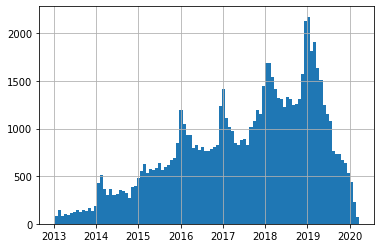

In [521]:
(X['operation_year'] + X['age']/365).hist(bins=100)

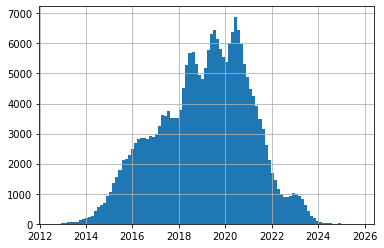

In [518]:
result['pred_resale_year'].hist(bins=100)

In [517]:
result['pred_resale_year'].round().value_counts().sort_index()

2013.0      182
2014.0     1556
2015.0     8047
2016.0    19030
2017.0    23903
2018.0    31485
2019.0    41917
2020.0    46161
2021.0    37734
2022.0    14905
2023.0     6846
2024.0     1220
2025.0       44
2026.0        2
Name: pred_resale_year, dtype: int64

In [546]:
X_train['primary_age'].value_counts(normalize=True).sort_index()

0.0     0.637353
1.0     0.283705
2.0     0.037620
3.0     0.021630
4.0     0.007305
5.0     0.003432
6.0     0.002463
7.0     0.002720
8.0     0.001481
9.0     0.000655
10.0    0.000427
11.0    0.000185
12.0    0.000100
13.0    0.000043
14.0    0.000128
15.0    0.000085
16.0    0.000142
17.0    0.000028
18.0    0.000014
19.0    0.000114
20.0    0.000085
21.0    0.000057
22.0    0.000028
23.0    0.000043
24.0    0.000014
25.0    0.000043
27.0    0.000014
28.0    0.000043
30.0    0.000014
31.0    0.000028
Name: primary_age, dtype: float64

In [541]:
X_train.head()

inn_seller        region_seller   activity_field_seller  \
vin                                                                          
X9PAG20A1DW111715  7453224139  Челябинская область  Коммерческие перевозки   
XVN45717KE3000746  7453090333  Челябинская область     Лизинговая компания   
VF617GKA000021676  7409007978  Челябинская область                     NaN   
X8958814KE2CE2005  7460015908  Челябинская область                     NaN   
X0V6712A2D1000002  7707648286               Москва                     NaN   

                           size_seller            name_seller  \
vin                                                             
X9PAG20A1DW111715                  NaN     ООО "ТРАНСХОЛДИНГ"   
XVN45717KE3000746  Средние предприятия      ООО "ТРАНСЛИЗИНГ"   
VF617GKA000021676     Микропредприятия           ООО "ФОРЕСТ"   
X8958814KE2CE2005                  NaN             7460015908   
X0V6712A2D1000002  Средние предприятия  ООО "ЭКСПРЕСС РИТЕЙЛ"   

                                                     activity_seller  \
vin                                                                    
X9PAG20A1DW111715  Деятельность вспомогательная прочая, связанная...   
XVN45717KE3000746  Деятельность по финансовой аренде (лизингу/суб...   
VF617GKA000021676  Деятельность агентов по оптовой торговле строи...   
X8958814KE2CE2005                                                NaN   
X0V6712A2D1000002  Деятельность агентов по оптовой торговле алког...   

                    status_seller activity_code_seller   risk_seller  \
vin                                                                    
X9PAG20A1DW111715  Реорганизуется                52.29  Высокий риск   
XVN45717KE3000746     Действующая                64.91   Низкий риск   
VF617GKA000021676     Действующая              46.13.2  Высокий риск   
X8958814KE2CE2005             NaN                  NaN           NaN   
X0V6712A2D1000002     Действующая             46.17.22  Высокий риск   

                            group_seller  \
vin                                        
X9PAG20A1DW111715     ООО "ТРАНСХОЛДИНГ"   
XVN45717KE3000746      ООО "ТРАНСЛИЗИНГ"   
VF617GKA000021676           ООО "ФОРЕСТ"   
X8958814KE2CE2005             7460015908   
X0V6712A2D1000002  ООО "ЭКСПРЕСС РИТЕЙЛ"   

                                               upper_activity_seller    brand  \
vin                                                                             
X9PAG20A1DW111715  Складское хозяйство и вспомогательная транспор...    VOLVO   
XVN45717KE3000746  Деятельность по предоставлению финансовых услу...    КАМАЗ   
VF617GKA000021676  Торговля оптовая, кроме оптовой торговли автот...  RENAULT   
X8958814KE2CE2005                                                NaN     УРАЛ   
X0V6712A2D1000002  Торговля оптовая, кроме оптовой торговли автот...    VOLVO   

                  chassis_config              body_type     model  \
vin                                                                 
X9PAG20A1DW111715            4x2        Тягач седельный  FH TRUCK   
XVN45717KE3000746            6x6               Автокран     43118   
VF617GKA000021676            4x2        Тягач седельный     AE480   
X8958814KE2CE2005            6x6                   Спец      4320   
X0V6712A2D1000002            4x2  Изотермический фургон  FL TRUCK   

                   operation_month  operation_day  primary_age  
vin                                                             
X9PAG20A1DW111715               10             22          0.0  
XVN45717KE3000746                4             11          0.0  
VF617GKA000021676                6             11          3.0  
X8958814KE2CE2005               11             20          0.0  
X0V6712A2D1000002                8             27          0.0

In [540]:
X.groupby('operation_year')['resale'].agg(['mean', 'median'])

mean       median
operation_year                          
2013            2016.375667  2016.202740
2014            2016.885296  2016.898630
2015            2017.504869  2017.605479
2016            2018.094304  2018.131507
2017            2018.614570  2018.649315
2018            2019.020686  2019.052055
2019            2019.510343  2019.473973
2020            2020.092237  2020.076712

mean       median
operation_year                          
2013            2015.654924  2015.690862
2014            2016.666700  2016.707798
2015            2017.638361  2017.687840
2016            2018.244053  2018.244553
2017            2019.104754  2019.038161
2018            2020.047903  2019.999746
2019            2021.039028  2021.009849
2020            2022.815615  2022.914435

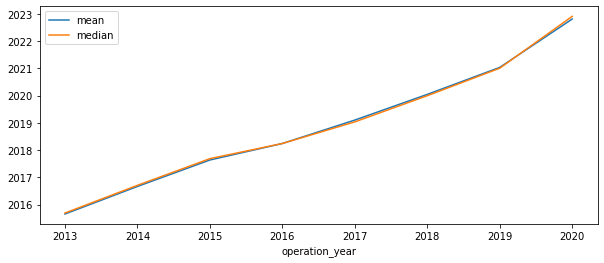

In [539]:
result.groupby('operation_year')['pred_resale_year'].agg(['mean', 'median']).plot(figsize=(10,4))
result.groupby('operation_year')['pred_resale_year'].agg(['mean', 'median'])

In [516]:
result[['operation_year', 'pred_resale_year']]

operation_year  pred_resale_year
0                 2013       2016.515694
1                 2013       2016.521412
2                 2013       2015.702162
3                 2013       2017.352258
4                 2013       2016.350597
...                ...               ...
233027            2020       2023.197466
233028            2020       2022.675653
233029            2020       2023.020460
233030            2020       2023.306039
233031            2020       2022.613117

[233032 rows x 2 columns]

In [449]:
tmp = result[['pred_age', 'pred_resale_year', 'year']].sample(10)#.merge(transaction_data[['inn_seller', 'age', 'operation_year']], left_index=True, right_index=True)
display(tmp)

pred_age  pred_resale_year    year
26694   1.489012       2014.489012  2013.0
179415  0.480072       2018.480072  2018.0
182180  0.827661       2018.827661  2018.0
87545   2.217723       2017.217723  2015.0
72288   2.208749       2017.208749  2015.0
64851   2.746192       2016.746192  2014.0
170726  0.519625       2018.519625  2018.0
117155  1.733630       2018.733630  2017.0
136346  1.154108       2018.154108  2017.0
127964  1.424274       2018.424274  2017.0

In [494]:
result = X_train.copy()
result['operation_year'] = year_train
result['pred_age'] = model.predict(X_train)/365
result['pred_resale_year'] = result['pred_age'] + result['operation_year']
result['age'] = y_train/365
result['error'] = result['age'] - result['pred_age']

In [495]:
result.groupby('operation_year')[['age', 'pred_age']].agg(['mean', 'median'])

age            pred_age          
                    mean    median      mean    median
operation_year                                        
2013            3.374346  3.198630  2.945711  3.142129
2014            2.886785  2.895890  2.729116  2.981071
2015            2.502625  2.601370  2.511521  2.687337
2016            2.094915  2.134247  2.146060  2.047535
2017            1.613878  1.646575  1.663574  1.478484
2018            1.025621  1.054795  1.176247  1.201418
2019            0.507825  0.471233  0.912704  0.919434
2020            0.092009  0.079452  0.527302  0.376817

In [511]:
result = X_test.copy()
result['operation_year'] = year_test
result['pred_age'] = model.predict(X_test)/365
result['pred_resale_year'] = result['pred_age'] + result['operation_year']
result['age'] = y_test/365
result['error'] = result['age'] - result['pred_age']

In [512]:
result.groupby('operation_year')[['age', 'pred_age']].agg(['mean', 'median'])

age            pred_age          
                    mean    median      mean    median
operation_year                                        
2013            3.353216  3.186301  2.847401  2.894316
2014            2.890401  2.915068  2.668737  2.745188
2015            2.596240  2.819178  2.573031  2.647518
2016            2.114096  2.205479  2.213884  2.209325
2017            1.627929  1.667123  1.778845  1.692306
2018            0.996446  1.030137  1.422348  1.284919

<BarContainer object of 1 artists>

<Figure size 1080x216 with 0 Axes>

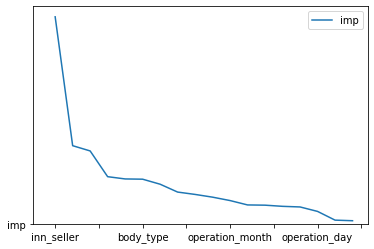

In [560]:
plt.figure(figsize=(15,3))
pd.DataFrame(data=model.feature_importances_, columns=['imp'], index=list(X_train)).sort_values('imp')[::-1].plot().bar(x='index', height='imp',)

In [550]:
pd.DataFrame(X_train.columns[np.argsort(model.feature_importances_)[::-1]])

Index(['inn_seller', 'model', 'activity_field_seller', 'upper_activity_seller',
       'region_seller', 'body_type', 'size_seller', 'chassis_config', 'brand',
       'risk_seller', 'operation_month', 'status_seller', 'activity_seller',
       'activity_code_seller', 'primary_age', 'operation_day', 'group_seller',
       'name_seller'],
      dtype='object')

In [437]:
# from xgboost import plot_importance
# from catboost import plot_importance
# from lightgbm import plot_importance

ImportError: cannot import name 'plot_importance' from 'catboost' (/opt/conda/lib/python3.7/site-packages/catboost/__init__.py)

In [133]:
plot_importance(model)

ValueError: tree must be Booster, XGBModel or dict instance

In [438]:
plt.figure(figsize=(15,5))
plot_importance(model)
plt.show()

NameError: name 'plot_importance' is not defined

<Figure size 1080x360 with 0 Axes>

In [451]:
y_pred

array([ 465.06629148,  237.0573366 , 1215.4774305 , ...,  923.75040425,
        186.38777352,  741.93906314])

In [454]:
pred = pd.Series(y_pred).to_frame('pred')
pred['round'] = y_pred.round().astype(int)
pred['act'] = y_test.values

In [455]:
pred

pred  round   act
0      465.066291    465   285
1      237.057337    237    68
2     1215.477431   1215   382
3     1005.328556   1005   899
4     1031.802785   1032   923
...           ...    ...   ...
7987   553.865679    554   751
7988  1063.261303   1063  1364
7989   923.750404    924  1097
7990   186.387774    186    49
7991   741.939063    742   483

[7992 rows x 3 columns]

In [440]:
pred.groupby('act')[['pred', 'round']].agg(['mean', 'median'])

pred                round        
             mean       median    mean  median
act                                           
8      232.217708   232.217708   232.0   232.0
9      616.540216   616.540216   617.0   617.0
10      33.986052    33.986052    34.0    34.0
11     232.217708   232.217708   232.0   232.0
12     137.806809   137.806809   138.0   138.0
...           ...          ...     ...     ...
2529  1593.180053  1593.180053  1593.0  1593.0
2538  2056.724795  2056.724795  2057.0  2057.0
2565  1698.955190  1698.955190  1699.0  1699.0
2573  1036.605496  1036.605496  1037.0  1037.0
2603  1099.824716  1099.824716  1100.0  1100.0

[2088 rows x 4 columns]

# SELECT NEW SELLERS

In [53]:
X_pred = transaction_data.loc[transaction_data['inn_seller'] == 'INITIAL']

X_pred[[
    'inn_seller',
    'region_seller',
    'activity_field_seller',
    'size_seller',
    'name_seller',
    'activity_seller',
    'status_seller',
    'activity_code_seller',
    'risk_seller',
    'group_seller',
    'upper_activity_seller',
]] =\
X_pred[[
    'inn_buyer',
    'region_buyer',
    'activity_field_buyer',
    'size_buyer',
    'name_buyer',
    'activity_buyer',
    'status_buyer',
    'activity_code_buyer',
    'risk_buyer',
    'group_buyer',
    'upper_activity_buyer',

]]

X_pred = X_pred[[
    'inn_seller',
    'region_seller',
    'activity_field_seller',
    'size_seller',
    'name_seller',
    'activity_seller',
    'status_seller',
    'activity_code_seller',
    'risk_seller',
    'group_seller',
    'upper_activity_seller',
    'brand',
    'chassis_config',
    'year',
    'body_type',
    'model',
    'vin'
]]

X_pred.drop_duplicates(inplace=True)
X_pred = X_pred.set_index('vin')

In [ ]:
le_dict = {}
for col in cat_features:
    X_train[col] = le.transform(X_train[col].fillna('NONE'))
    X_test[col] = le.transform(X_test[col].fillna('NONE'))
    le_dict[col] = le

# 2nd METHOD

In [347]:
tmp = (transaction_data['inn_seller'] == 'INITIAL').groupby(transaction_data['vin']).sum()
vin_list = tmp[tmp == 1].index.tolist()

In [339]:
transaction_data.loc[transaction_data['vin'] == 'XUB4784D1C0000175']

inn_seller   inn_buyer        region_seller activity_field_seller  \
1328    INITIAL  3666124413                  NaN                   NaN   
1330    INITIAL  3666124413  Воронежская область                  None   

             region_buyer activity_field_buyer                vin  brand  \
1328  Воронежская область                 None  XUB4784D1C0000175  ISUZU   
1330  Воронежская область                 None  XUB4784D1C0000175  ISUZU   

     chassis_config    year body_type   model  age operation_date  \
1328            4x2  2012.0    Фургон  NPR75L    1     2013-01-10   
1330            4x2  2012.0    Фургон  NPR75L    1     2013-01-10   

           operation_reason  operation_year size_seller name_seller  \
1328  первичная регистрация            2013         NaN     INITIAL   
1330  первичная регистрация            2013         NaN     INITIAL   

     activity_seller status_seller activity_code_seller risk_seller  \
1328             NaN           NaN                  NaN         NaN   
1330             NaN           NaN                  NaN         NaN   

     group_seller upper_activity_seller        size_buyer name_buyer  \
1328      INITIAL                   NaN  Микропредприятия  ООО "ВМС"   
1330      INITIAL                   NaN  Микропредприятия  ООО "ВМС"   

                                         activity_buyer status_buyer  \
1328  Аренда и управление собственным или арендованн...  Действующая   
1330  Аренда и управление собственным или арендованн...  Действующая   

     activity_code_buyer    risk_buyer group_buyer  \
1328               68.20  Средний риск   ООО "ВМС"   
1330               68.20  Средний риск   ООО "ВМС"   

                   upper_activity_buyer  operation_month  operation_day  ord  
1328  Операции с недвижимым имуществом                 1             10    1  
1330  Операции с недвижимым имуществом                 1             10    1

In [338]:
transaction_data.loc[transaction_data.sort_values('operation_date').groupby('vin')['inn_seller'].shift() == 'INITIAL']

inn_seller   inn_buyer         region_seller   activity_field_seller  \
1328        INITIAL  3666124413                   NaN                     NaN   
8845        INITIAL  6672294881  Свердловская область                    None   
16153    7736578996  4211002950                Москва     Лизинговая компания   
16635    7736578996  4211002950                Москва     Лизинговая компания   
17514    6165154243  6165031467    Ростовская область                    None   
...             ...         ...                   ...                     ...   
1635501  7705999472  3702579360     Рязанская область     Лизинговая компания   
1635512  5504135133  5404084044        Омская область  Коммерческие перевозки   
1635514  1639043296  3702729720             Татарстан  Коммерческие перевозки   
1635524     INITIAL  6317143792    Московская область  Коммерческие перевозки   
1635564  0264066195  1650314976          Башкортостан            Строительная   

                  region_buyer activity_field_buyer                vin  \
1328       Воронежская область                 None  XUB4784D1C0000175   
8845      Свердловская область                 None  X6569280KC0001686   
16153      Кемеровская область                 None  X0P684020C0000005   
16635      Кемеровская область                 None  X0P684020C0000008   
17514       Ростовская область                 None  X89385810C0BW1038   
...                        ...                  ...                ...   
1635501     Ивановская область                 None  XD2476200HB000170   
1635512  Новосибирская область                 None  WMA24XZZ3JM796876   
1635514     Ивановская область                 None  9BSR4X20003891254   
1635524     Ростовская область                 None  WDB96340310275330   
1635564           Башкортостан                 None  LZGJRDR44HX127157   

                 brand chassis_config    year  \
1328             ISUZU            4x2  2012.0   
8845             КАМАЗ            6x4  2012.0   
16153            КАМАЗ            6x4  2012.0   
16635            КАМАЗ            6x4  2012.0   
17514            КАМАЗ            6x6  2012.0   
...                ...            ...     ...   
1635501     MITSUBISHI            4x2  2017.0   
1635512            MAN            6x2  2018.0   
1635514         SCANIA            4x2  2016.0   
1635524  MERCEDES-BENZ            4x2  2018.0   
1635564    SHAANXI MAN            6x4  2017.0   

                               body_type   model  age operation_date  \
1328                              Фургон  NPR75L    1     2013-01-10   
8845     Комбинированная дорожная машина   53229    1     2013-01-24   
16153                    Грузовые прочие    6520    1     2013-02-07   
16635                    Грузовые прочие    6520    1     2013-02-07   
17514                             Фургон   43114    1     2013-02-08   
...                                  ...     ...  ...            ...   
1635501                     Рефрижератор    FUSO    3     2020-03-31   
1635512                  Тягач седельный  26.440    2     2020-03-31   
1635514                  Тягач седельный  R440LA    4     2020-03-31   
1635524                  Тягач седельный    1848    2     2020-03-31   
1635564                         Самосвал  SX3256    3     2020-03-31   

                                          operation_reason  operation_year  \
1328                                 первичная регистрация            2013   
8845                                 первичная регистрация            2013   
16153    временная регистрация ТС (на срок проведения п...            2013   
16635    временная регистрация ТС (на срок проведения п...            2013   
17514    Изменение собственника по сделкам, произведенн...            2013   
...                                                    ...             ...   
1635501                        регистрация, снятых с учета            2020   
1635512  Изменение собственника по сделкам, произведенн...           

In [13]:
transaction_data['inn_seller'].value_counts()

INITIAL       444288
ФИЗ ЛИЦО       15075
8904037873      1804
6164077483      1190
5032048798      1159
               ...  
7017021509         1
7751508136         1
7710121637         1
2311980148         1
3662181298         1
Name: inn_seller, Length: 76271, dtype: int64

In [16]:
transaction_data.groupby('vin')['inn_seller'].shift().fillna('')

0                    
1                    
2                    
3                    
4                    
              ...    
1635578              
1635579    6671335486
1635580              
1635581              
1635582              
Name: inn_seller, Length: 1635583, dtype: object

In [17]:
transaction_data.groupby('vin')['inn_seller'].shift() == 'INITIAL'

0          False
1          False
2          False
3          False
4          False
           ...  
1635578    False
1635579    False
1635580    False
1635581    False
1635582    False
Name: inn_seller, Length: 1635583, dtype: bool

In [21]:
transaction_data.loc[transaction_data['vin'] == 'X6569280KC0001686']

inn_seller   inn_buyer         region_seller activity_field_seller  \
8841    INITIAL  6672294881                   NaN                   NaN   
8845    INITIAL  6672294881  Свердловская область                  None   

              region_buyer activity_field_buyer                vin  brand  \
8841  Свердловская область                 None  X6569280KC0001686  КАМАЗ   
8845  Свердловская область                 None  X6569280KC0001686  КАМАЗ   

     chassis_config    year                        body_type  model  age  \
8841            6x4  2012.0  Комбинированная дорожная машина  53229    1   
8845            6x4  2012.0  Комбинированная дорожная машина  53229    1   

     operation_date       operation_reason  operation_year size_seller  \
8841     2013-01-24  первичная регистрация            2013         NaN   
8845     2013-01-24  первичная регистрация            2013         NaN   

     name_seller activity_seller status_seller activity_code_seller  \
8841     INITIAL             NaN           NaN                  NaN   
8845     INITIAL             NaN           NaN                  NaN   

     risk_seller group_seller upper_activity_seller size_buyer  \
8841         NaN      INITIAL                   NaN       None   
8845         NaN      INITIAL                   NaN       None   

                 name_buyer  \
8841  МБУ "ОКТЯБРЬСКИЙ ДЭУ"   
8845  МБУ "ОКТЯБРЬСКИЙ ДЭУ"   

                                         activity_buyer status_buyer  \
8841  Деятельность по эксплуатации автомобильных дор...  Действующая   
8845  Деятельность по эксплуатации автомобильных дор...  Действующая   

     activity_code_buyer risk_buyer            group_buyer  \
8841            52.21.22       None  МБУ "ОКТЯБРЬСКИЙ ДЭУ"   
8845            52.21.22       None  МБУ "ОКТЯБРЬСКИЙ ДЭУ"   

                                   upper_activity_buyer  
8841  Складское хозяйство и вспомогательная транспор...  
8845  Складское хозяйство и вспомогательная транспор...

In [14]:
transaction_data.loc[transaction_data.groupby('vin')['inn_seller'].shift() == 'INITIAL']

inn_seller   inn_buyer         region_seller   activity_field_seller  \
1330        INITIAL  3666124413   Воронежская область                    None   
8845        INITIAL  6672294881  Свердловская область                    None   
16153    7736578996  4211002950                Москва     Лизинговая компания   
16635    7736578996  4211002950                Москва     Лизинговая компания   
17514    6165154243  6165031467    Ростовская область                    None   
...             ...         ...                   ...                     ...   
1635501  7705999472  3702579360     Рязанская область     Лизинговая компания   
1635512  5504135133  5404084044        Омская область  Коммерческие перевозки   
1635514  1639043296  3702729720             Татарстан  Коммерческие перевозки   
1635524     INITIAL  6317143792    Московская область  Коммерческие перевозки   
1635564  0264066195  1650314976          Башкортостан            Строительная   

                  region_buyer activity_field_buyer                vin  \
1330       Воронежская область                 None  XUB4784D1C0000175   
8845      Свердловская область                 None  X6569280KC0001686   
16153      Кемеровская область                 None  X0P684020C0000005   
16635      Кемеровская область                 None  X0P684020C0000008   
17514       Ростовская область                 None  X89385810C0BW1038   
...                        ...                  ...                ...   
1635501     Ивановская область                 None  XD2476200HB000170   
1635512  Новосибирская область                 None  WMA24XZZ3JM796876   
1635514     Ивановская область                 None  9BSR4X20003891254   
1635524     Ростовская область                 None  WDB96340310275330   
1635564           Башкортостан                 None  LZGJRDR44HX127157   

                 brand chassis_config    year  \
1330             ISUZU            4x2  2012.0   
8845             КАМАЗ            6x4  2012.0   
16153            КАМАЗ            6x4  2012.0   
16635            КАМАЗ            6x4  2012.0   
17514            КАМАЗ            6x6  2012.0   
...                ...            ...     ...   
1635501     MITSUBISHI            4x2  2017.0   
1635512            MAN            6x2  2018.0   
1635514         SCANIA            4x2  2016.0   
1635524  MERCEDES-BENZ            4x2  2018.0   
1635564    SHAANXI MAN            6x4  2017.0   

                               body_type   model  age operation_date  \
1330                              Фургон  NPR75L    1     2013-01-10   
8845     Комбинированная дорожная машина   53229    1     2013-01-24   
16153                    Грузовые прочие    6520    1     2013-02-07   
16635                    Грузовые прочие    6520    1     2013-02-07   
17514                             Фургон   43114    1     2013-02-08   
...                                  ...     ...  ...            ...   
1635501                     Рефрижератор    FUSO    3     2020-03-31   
1635512                  Тягач седельный  26.440    2     2020-03-31   
1635514                  Тягач седельный  R440LA    4     2020-03-31   
1635524                  Тягач седельный    1848    2     2020-03-31   
1635564                         Самосвал  SX3256    3     2020-03-31   

                                          operation_reason  operation_year  \
1330                                 первичная регистрация            2013   
8845                                 первичная регистрация            2013   
16153    временная регистрация ТС (на срок проведения п...            2013   
16635    временная регистрация ТС (на срок проведения п...            2013   
17514    Изменение собственника по сделкам, произведенн...            2013   
...                                                    ...             ...   
1635501                        регистрация, снятых с учета            2020   
1635512  Изменение собственника по сделкам, произведенн...           

In [167]:
transaction_data['vin']

inn_seller   inn_buyer         region_seller   activity_field_seller  \
0               NaN  1117006246                   NaN                     NaN   
1               NaN  6321304058                   NaN                     NaN   
2               NaN  7422032998                   NaN                     NaN   
3               NaN  6321304058                   NaN                     NaN   
4               NaN  6321304058                   NaN                     NaN   
...             ...         ...                   ...                     ...   
1635578     INITIAL  7810093863                   NaN                     NaN   
1635579  6663006255  0272906610  Свердловская область  Коммерческие перевозки   
1635580     INITIAL  5603007580                   NaN                     NaN   
1635581     INITIAL  5603007580                   NaN                     NaN   
1635582         NaN  0277039262                   NaN                     NaN   

                 region_buyer activity_field_buyer                vin  brand  \
0                        Коми                 None  X52AT630S70000035  КАМАЗ   
1           Самарская область                 None  XLRTE85XC0E758580    DAF   
2         Челябинская область  Лизинговая компания  XTC651163C1252268  КАМАЗ   
3           Самарская область                 None  XLERTE85XC0E75785    DAF   
4           Самарская область                 None  XLRTE85XC0E758586    DAF   
...                       ...                  ...                ...    ...   
1635578       Санкт-Петербург                 None  XTC652005L1416950  КАМАЗ   
1635579          Башкортостан                 None  X9PAS02A3CW107888  VOLVO   
1635580  Оренбургская область                 None  X89509811L0FZ6109  КАМАЗ   
1635581  Оренбургская область                 None  X89509811L0FZ6108  КАМАЗ   
1635582          Башкортостан                 None  X895811T2E0AB5030  КАМАЗ   

        chassis_config    year                                  body_type  \
0                  6x4  2007.0                            Грузовые прочие   
1                  8x4  2007.0                            Тягач седельный   
2                  6x4  2012.0                            Тягач седельный   
3                  8x4  2007.0                            Тягач седельный   
4                  8x4  2007.0                            Тягач седельный   
...                ...     ...                                        ...   
1635578            6x4  2020.0                                   Самосвал   
1635579            4x2  2012.0                            Тягач седельный   
1635580            6x6  2020.0  Установка промысловая паровая передвижная   
1635581            6x6  2020.0  Установка промысловая паровая передвижная   
1635582            4x2  2014.0                             Автогудронатор   

            model  age operation_date  \
0            6520    6     2013-01-02   
1        CF85.340    6     2013-01-03   
2           65116    1     2013-01-03   
3        CF85.340    6     2013-01-03   
4        CF85.340    6     2013-01-03   
...           ...  ...            ...   
1635578      6520    0     2020-03-31   
1635579  FH TRUCK    8     2020-03-31   
1635580     43118    0     2020-03-31   
1635581     43118    0     2020-03-31   
1635582     43253    6     2020-03-31   

                                          operation_reason  operation_year  \
0        Изменение собственника по сделкам, произведенн...            2013   
1                                коррекция иных реквизитов            2013   
2        временная регистрация ТС (на срок проведения п...            2013   
3                                коррекция иных реквизитов            2013   
4                                коррекция иных реквизитов            2013   
...                                                    ...             ...   
1635578                              первичная регистрация            2020   
1635579                        ре

In [ ]:
OPERATION_REASONS = [
    'Изменение собственника по сделкам, произведенным в любой форме с сохранением государственных регистрационных знаков',
    'Изменение собственника по сделкам, произведенным в любой форме (купля-продажа, дарение, др.) с заменой  государственных регистрационных знаков'
]

FEATURES = [
    'inn_seller',
    'region_seller',
    'activity_field_seller',
    'size_seller',
    'name_seller',
    'activity_seller',
    'status_seller',
    'activity_code_seller',
    'risk_seller',
    'group_seller',
    'upper_activity_seller',
    
    'brand',
    'chassis_config',
    'year',
    'body_type',
    'model',
]

TARGET = 'age'

#################################

X = transaction_data.loc[transaction_data.groupby('vin')['operation_reason'].shift() == 'первичная регистрация']
X = X.loc[X['operation_reason'].isin(OPERATION_REASONS)]

MAX_AGE = 10
X = X.loc[X['age'] < MAX_AGE]

y = X[TARGET]
X = X[FEATURES]